In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import itertools
from collections import Counter
from networkx.drawing.nx_agraph import graphviz_layout
import statistics
import seaborn as sns
from skbio.stats.composition import multiplicative_replacement
from skbio.stats.composition import clr
from tqdm import tqdm

In [2]:
healthyNetwork = nx.read_gexf("./Files/Networks/healthyNetwork_168.gexf")
crcNetwork = nx.read_gexf("./Files/Networks/crcNetwork_168.gexf")

In [3]:
accTaxDictDF = pd.read_csv("./Files/Dataframes/Master_Rename.csv").set_index("Bacterial_Strain")
accTaxDictDF['Species'] = accTaxDictDF['Species'].astype(str)
accTaxDictDF.head()

accTaxDictDF2 = accTaxDictDF.reset_index().set_index("Species").copy()

accTaxDictDF3 = accTaxDictDF2.loc[~accTaxDictDF2.index.duplicated(keep='first')].copy()

In [4]:
def inspectNodes(df):
    df2 = df.copy()
    
    generaList = []

    for i in list(df2.index):
        generaList.append((accTaxDictDF3.at[i.replace(".","-"), 'Genus']))
    
    generaList2 = list(set(generaList))

    tempDF = pd.DataFrame(index=generaList2, columns=['Healthy','CRC'])
    tempDF.fillna(0, inplace=True)

    for i in tempDF.columns:
        for x in df2[df2['Cohort']==i].dropna().index:
            tempDF.at[str(accTaxDictDF3.at[x.replace(".","-"), 'Genus']), i] += 1
            
    tempDF['Healthy'] = tempDF[['Healthy']].div(tempDF[['Healthy']].sum())
    tempDF['CRC'] = tempDF[['CRC']].div(tempDF[['CRC']].sum())
    
    orderList = sorted(list(tempDF.index))
    
    tempDF2 = tempDF.loc[orderList].T.copy()
            
    return (tempDF2)

In [5]:
def inspectNodesGenusCount(df):
    df2 = df.copy()
    
    generaList = []

    for i in list(df2.index):
        generaList.append((accTaxDictDF3.at[i.replace(".","-"), 'Genus']))
    
    generaList2 = list(set(generaList))

    tempDF = pd.DataFrame(index=generaList2, columns=['Healthy','CRC'])
    tempDF.fillna(0, inplace=True)

    for i in tempDF.columns:
        for x in df2[i].dropna().index:
            tempDF.at[str(accTaxDictDF3.at[x.replace(".","-"), 'Genus']), i] += 1
    
    orderList = sorted(list(tempDF.index))
    
    tempDF2 = tempDF.loc[orderList].T.copy()
            
    return (tempDF2)

In [6]:
def inspectNodesSpecies(df):
    df2 = df.copy()
    
    generaList = []

    for i in list(df2.index):
        generaList.append(i)
    
    generaList2 = list(set(generaList))

    tempDF = pd.DataFrame(index=generaList2, columns=['Healthy','CRC'])
    tempDF.fillna(0, inplace=True)

    for i in tempDF.columns:
        for x in df2[df2['Cohort']==i].dropna().index:
            tempDF.at[str(x), i] += 1
    
    orderList = sorted(list(tempDF.index))
    
    tempDF2 = tempDF.loc[orderList].T.copy()
            
    return (tempDF2)

## Import Functional Potential DataFrame

In [7]:
crcSF_pfam = pd.read_csv("./Files/Dataframes/Functional/crcSpecies_PFAMs.csv")
healthtySF_pfam = pd.read_csv("./Files/Dataframes/Functional/japaneseSpecies_PFAMs.csv")

crcSF_pfam.rename(columns={'Unnamed: 0':'Bacterial_Species'}, inplace=True)
healthtySF_pfam.rename(columns={'Unnamed: 0':'Bacterial_Species'}, inplace=True)

crcSF_pfam.set_index("Bacterial_Species", inplace=True)
healthtySF_pfam.set_index("Bacterial_Species", inplace=True)

## Load Node DataFrames for all Countries

In [8]:
healthyDF = pd.read_csv('./Files/Dataframes/healthy_Node_properties_168.csv').set_index("Bacterial_Species").sort_values(by='Degree_Centrality', ascending=False)
crcDF = pd.read_csv('./Files/Dataframes/crc_Node_properties_168.csv').set_index("Bacterial_Species").sort_values(by='Degree_Centrality', ascending=False)

In [9]:
allNodeDF = pd.concat([healthyDF, crcDF])
allNodeDF_pos = allNodeDF[allNodeDF['Negative_Edges']==0].copy()

## Load partitions

In [10]:
crcPartitions_temp = set(line.strip() for line in open('./Files/Networks/crcPartitions_168.txt'))
healthyPartitions_temp = set(line.strip() for line in open('./Files/Networks/healthyPartitions_168.txt'))

crcPartitions = []
healthyPartitions = []

for x in crcPartitions_temp:
        tempSet = list()
        for y in x.split(","):
            tempSet.append(y.split("'")[1])
        crcPartitions.append(set(tempSet))     
        
for x in healthyPartitions_temp:
        tempSet = list()
        for y in x.split(","):
            tempSet.append(y.split("'")[1])
        healthyPartitions.append(set(tempSet)) 

## Pull Top Bacteria in each category

In [11]:
def dfCommunityTop(df,partitions,chosenColumn):
    
    df2 = df.copy()
    
    TopDogs = []

    for i in partitions:
        if len(i) > 2:
            
            pullThese = []
            for x in i:
                pullThese.append(x)
                
            #Out of the pulled species which has the most associations
            TopDogs.append(df2.loc[pullThese].sort_values(by=chosenColumn, ascending=False).index[0])           
    
    return(df2.loc[TopDogs])

In [12]:
def dfModuleTop_noFullNetwork(df, network,partitions,chosenColumn):
    df2 = df.copy()
    TopDogs = []

    for i in partitions:
        if len(i) > 2:
        
            G = americanNetwork.subgraph(i)
            if chosenColumn == 'Degree_Centrality':
                tempDict = nx.degree_centrality(G)
                
                tempHold = []
                currentLeader = 'none'
                currentGoal = 0.0
                
                for x,y in tempDict.items():
                    if y > currentGoal:
                        tempHold.append(x)
                        currentGoal = y
                        
                    elif y == currentGoal:
                        tempHold.append(x)
                        currentGoal = y
                        
                    else:
                        continue
                        
                topDOOG = df2.loc[tempHold].sort_values(by=chosenColumn, ascending=False).index[0]
                        
                TopDogs = TopDogs + tempHold
                    
            else:
                tempDict = nx.betweenness_centrality(G)
                
                tempHold = []
                currentLeader = 'none'
                currentGoal = 0.0
                
                for x,y in tempDict.items():
                    if float(y) > currentGoal:
                        tempHold.append(x)
                        currentLeader = x
                        currentGoal = y
                        if len(tempHold) > 0:
                            tempHold.remove(currentLeader)
                        else:
                            continue
                        
                    elif y == currentGoal:
                        tempHold.append(x)
                        currentLeader = x
                        currentGoal = y
                        
                    else:
                        continue
                        
                TopDogs = TopDogs + tempHold
    
    return(df2.loc[TopDogs])

In [13]:
def ModuleHubs(df, network,partitions,chosenColumn):
    df2 = df.copy()
    TopDogs = []

    for i in partitions:
        if len(i) > 2:
        
            G = network.subgraph(i)
            
            tempDict = nx.degree_centrality(G)
                
            tempHold = []
            currentLeader = 'none'
            currentGoal = 0.0
                
            for x,y in tempDict.items():
                if y > currentGoal:
                    tempHold.append(x)
                    currentGoal = y
                        
                elif y == currentGoal:
                    tempHold.append(x)
                    currentGoal = y
                        
                else:
                    continue
                        
                
            if len(tempHold) > 1:
                topDOOG = df2.loc[tempHold].sort_values(by=chosenColumn, ascending=False).index[0]
                TopDogs.append(topDOOG)
            else:
                TopDogs = TopDogs + tempHold
    
    return(df2.loc[TopDogs])

In [14]:
# Look at the Degree Assorsativity of each modules within each network
def ModuleAssortativity(network,partitions,cohort):
    
    tempdict = {"Module":[],"Degree_Assortativity":[],"Cohort":[]}
    for i in partitions:
        if len(i) > 2:
            G = network.subgraph(i)
            tempdict['Module'].append(i)
            tempdict['Degree_Assortativity'].append(nx.degree_assortativity_coefficient(G))
            tempdict['Cohort'].append(cohort)
        else:
            continue
            
    tempdf = pd.DataFrame(data=tempdict)
    return tempdf                

In [15]:
def dfStripTop(df, chosenColumn):
    
    df2 = df.sort_values(by=chosenColumn, ascending=False).reset_index().copy()
    CohortDict = {x: 0 for x in set(df['Cohort'])}
    
    for row in df2.index:
        if CohortDict[df2.at[row,'Cohort']] < 5:
            CohortDict[df2.at[row,'Cohort']] +=1
            continue
        else:
            df2.drop(index=row, inplace=True)
    return(df2.set_index("Bacterial_Species"))

In [16]:
def dfStripTop_Pos(df, chosenColumn):
    
    crcmax = df[df["Cohort"]=='CRC'][chosenColumn].max()
    temp1 = df[(df["Cohort"]=='CRC') & (df[chosenColumn]==crcmax)].copy()
    
    japanesemax = df[df["Cohort"]=='Healthy'][chosenColumn].max()
    temp2 = df[(df["Cohort"]=='Healthy') & (df[chosenColumn]==japanesemax)].copy()
    
    tempdf = pd.concat([temp1, temp2])
    return(tempdf)

## Module Degree Assortativity

In [17]:
healthyMDA = ModuleAssortativity(healthyNetwork,healthyPartitions,"Healthy")
#Degree assortativity returns NaN for perfect assortativiy so replace with 1
healthyMDA.fillna(1, inplace=True)

/home/mark/anaconda3/lib/python3.6/site-packages/networkx/algorithms/assortativity/correlation.py:288: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / numpy.sqrt(vara * varb)


In [18]:
crcMDA = ModuleAssortativity(crcNetwork,crcPartitions,"CRC")
#Degree assortativity returns NaN for perfect assortativiy so replace with 1
crcMDA.fillna(1, inplace=True)

/home/mark/anaconda3/lib/python3.6/site-packages/networkx/algorithms/assortativity/correlation.py:288: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / numpy.sqrt(vara * varb)


In [19]:
allMDA = pd.concat([healthyMDA,crcMDA]).dropna()
allMDA.head()

,Module,Degree_Assortativity,Cohort
0,"{Bacteroides_salanitronis, Bacteroides_helcoge...",-0.080357,Healthy
1,"{Johnsonella_ignava, Holdemania_massiliensis, ...",-1.000000,Healthy
2,"{Angelakisella_massiliensis, Traorella_massili...",-0.489362,Healthy
3,"{Marvinbryantia_formatexigens, Clostridium_spo...",-0.509804,Healthy
4,"{Granulicatella_adiacens, Streptococcus_mitis,...",1.000000,Healthy


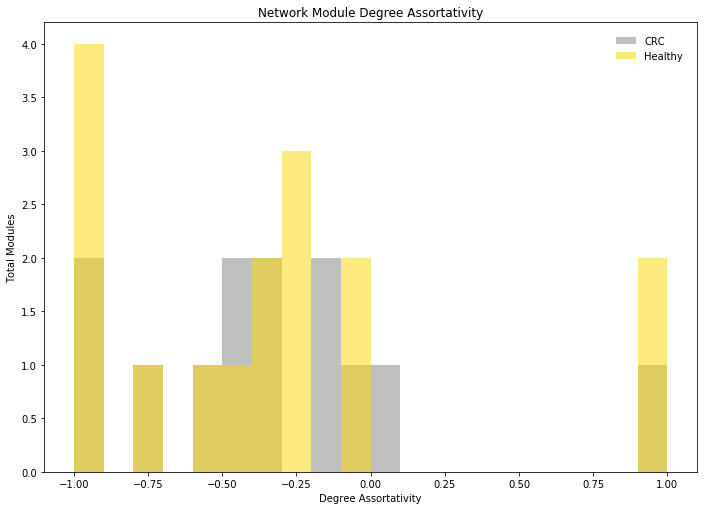

In [20]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 11.7,8.27

palette ={"Healthy":'gold', "CRC":'grey'}


#sns.set_palette(palette=palette.values())
for Cohort in set(allMDA['Cohort']):
    subset = allMDA[allMDA['Cohort'] == Cohort].copy()
    sns_hist = sns.distplot(subset['Degree_Assortativity'], color=palette[Cohort] ,hist = True, kde = False, bins=[-1.0,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], label = Cohort, hist_kws={"alpha": 0.5})
    
# Plot formatting
plt.title('Network Module Degree Assortativity')
plt.xlabel('Degree Assortativity')
plt.ylabel('Total Modules')
plt.legend(loc=1, borderaxespad=1,framealpha=1, edgecolor='white', facecolor='white')

axes = plt.gca()
#axes.set_ylim([0,4])

plt.show()
fig = sns_hist.get_figure()
#fig.savefig("Module_DA.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [21]:
for i in allMDA.index:
    for x in (allMDA.at[i,'Module']):
        print(x)
        for y in x:
            print(y)

{'Bacteroides_salanitronis', 'Bacteroides_helcogenes', 'Bacteroides_barnesiae', 'Paraprevotella_xylaniphila', 'Culturomica_massiliensis', 'Mediterranea_massiliensis', 'Coprobacter_fastidiosus', 'Prevotellamassilia_timonensis'}
Bacteroides_salanitronis
Bacteroides_helcogenes
Bacteroides_barnesiae
Paraprevotella_xylaniphila
Culturomica_massiliensis
Mediterranea_massiliensis
Coprobacter_fastidiosus
Prevotellamassilia_timonensis
{'Peptostreptococcus_stomatis', 'Parvimonas_micra', 'Gemella_morbillorum', 'Dialister_pneumosintes'}
Peptostreptococcus_stomatis
Parvimonas_micra
Gemella_morbillorum
Dialister_pneumosintes
{'Johnsonella_ignava', 'Holdemania_massiliensis', 'Ruminococcus_bicirculans'}
Johnsonella_ignava
Holdemania_massiliensis
Ruminococcus_bicirculans
{'Bacteroides_helcogenes', 'Bacteroides_fluxus', 'Bacteroides_coprophilus', 'Bacteroides_barnesiae', 'Paraprevotella_xylaniphila', 'Bacteroides_plebeius', 'Mediterranea_massiliensis'}
Bacteroides_helcogenes
Bacteroides_fluxus
Bacteroide

In [22]:
allMDA.head()

,Module,Degree_Assortativity,Cohort
0,"{Bacteroides_salanitronis, Bacteroides_helcoge...",-0.080357,Healthy
1,"{Johnsonella_ignava, Holdemania_massiliensis, ...",-1.000000,Healthy
2,"{Angelakisella_massiliensis, Traorella_massili...",-0.489362,Healthy
3,"{Marvinbryantia_formatexigens, Clostridium_spo...",-0.509804,Healthy
4,"{Granulicatella_adiacens, Streptococcus_mitis,...",1.000000,Healthy


In [23]:
for i in (allMDA[allMDA['Degree_Assortativity']<0.0]['Module']):
    print(i)

{'Bacteroides_salanitronis', 'Bacteroides_helcogenes', 'Bacteroides_barnesiae', 'Paraprevotella_xylaniphila', 'Culturomica_massiliensis', 'Mediterranea_massiliensis', 'Coprobacter_fastidiosus', 'Prevotellamassilia_timonensis'}
{'Johnsonella_ignava', 'Holdemania_massiliensis', 'Ruminococcus_bicirculans'}
{'Angelakisella_massiliensis', 'Traorella_massiliensis', 'Blautia_schinkii', 'Lactonifactor_longoviformis', 'Anaerotruncus_colihominis', 'Clostridium_symbiosum'}
{'Marvinbryantia_formatexigens', 'Clostridium_sporogenes', 'Coprococcus_eutactus', 'Monoglobus_pectinilyticus', 'Eubacterium_ventriosum', 'Butyrivibrio_crossotus', 'Lactobacillus_rogosae', 'Eubacterium_eligens'}
{'Streptococcus_sp_FDAARGOS_192', 'Streptococcus_parasanguinis', 'Streptococcus_sp_A12', 'Streptococcus_salivarius'}
{'Bacteroides_heparinolyticus', 'Bacteroides_caccae', 'Parabacteroides_goldsteinii', 'Odoribacter_splanchnicus', 'Bacteroides_pyogenes', 'Bacteroides_cellulosilyticus', 'Coprobacter_secundus', 'Bacteroide

In [24]:
def ModuleHubs_OnlyHubs(df, network,partitions1,chosenColumn, cohort):
    df2 = df.copy()
    TopDogs = []

    partitions = partitions1[partitions1['Cohort']==cohort].copy()
    
    for i in partitions[partitions['Degree_Assortativity']<0.0]['Module']:
        
        if len(i) > 2:
        
            G = network.subgraph(i)
            
            tempDict = nx.degree_centrality(G)
                
            tempHold = []
            currentLeader = 'none'
            currentGoal = 0.0
                
            for x,y in tempDict.items():
                if y > currentGoal:
                    tempHold.append(x)
                    currentGoal = y
                        
                elif y == currentGoal:
                    tempHold.append(x)
                    currentGoal = y
                        
                else:
                    continue
                        
                
            if len(tempHold) > 1:
                topDOOG = df2.loc[tempHold].sort_values(by=chosenColumn, ascending=False).index[0]
                TopDogs.append(topDOOG)
            else:
                TopDogs = TopDogs + tempHold
    
    return(df2.loc[TopDogs])

In [25]:
#Find Hub species in each Module
healthyModuleHubs = ModuleHubs_OnlyHubs(healthyDF,healthyNetwork,allMDA,'Degree_Centrality','Healthy')
crcModuleHubs = ModuleHubs_OnlyHubs(crcDF,crcNetwork,allMDA,'Degree_Centrality','CRC')

allDegComNodesDF2 = pd.concat([healthyModuleHubs,crcModuleHubs])
allDegComNodesDF2.head()

,Mean_Relative_Abundance,Total_Edges,Positive_Edges,Negative_Edges,Triangles,Degree_Centrality,Clustering_Coefficient,Harmonic_Centrality,Betweenness_Centrality,Cohort
Bacterial_Species,,,,,,,,,,
Bacteroides_salanitronis,0.000922,9,9,0,8,0.054878,0.222222,37.317063,0.031028,Healthy
Johnsonella_ignava,0.000119,2,2,0,0,0.012195,0.000000,24.145238,0.008080,Healthy
Anaerotruncus_colihominis,0.000937,8,8,0,10,0.048780,0.357143,37.394048,0.022667,Healthy
Butyrivibrio_crossotus,0.000402,5,5,0,4,0.030488,0.400000,26.504762,0.046349,Healthy
Streptococcus_sp_FDAARGOS_192,0.002244,3,3,0,1,0.018293,0.333333,3.000000,0.000150,Healthy


In [26]:
##HUBS
ComDegSpeciesModules = inspectNodesSpecies(allDegComNodesDF2)
ComDegGeneraModules = inspectNodes(allDegComNodesDF2)

In [27]:
#ComDegSpeciesModules.to_csv("/home/mark/Desktop/CRCvsHealthy/highDegreeSpecies_168")

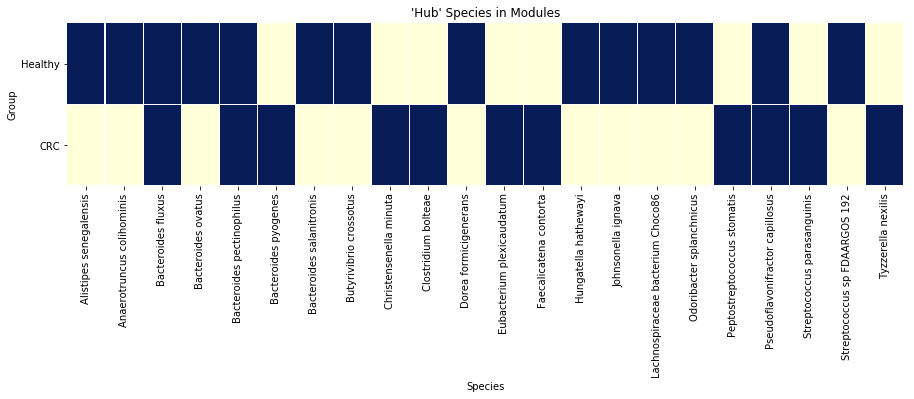

In [28]:
fig, ax = plt.subplots(figsize=(15,3))
for indexName3 in ComDegSpeciesModules.columns:
        ComDegSpeciesModules.rename(columns={indexName3:indexName3.replace("_"," ")}, inplace=True)
sns.heatmap(ComDegSpeciesModules, annot=False,xticklabels=1, cbar=False, yticklabels=1, linewidths=.05, ax=ax, cmap="YlGnBu")
plt.title("'Hub' Species in Modules")
plt.ylabel("Group")
plt.xlabel("Species")
plt.yticks(rotation=0)

#plt.savefig("/home/mark/Desktop/CRCvsHealthy/Images/highDegree_Species.png", dpi=300, bbox_inches='tight')
#plt.savefig("/home/mark/Desktop/CRCvsHealthy/Images/highDegree_Species.svg", dpi=300, bbox_inches='tight')
#plt.savefig("/home/mark/Desktop/CRCvsHealthy/Images/highDegree_Species.pdf", dpi=300, bbox_inches='tight')
plt.show()

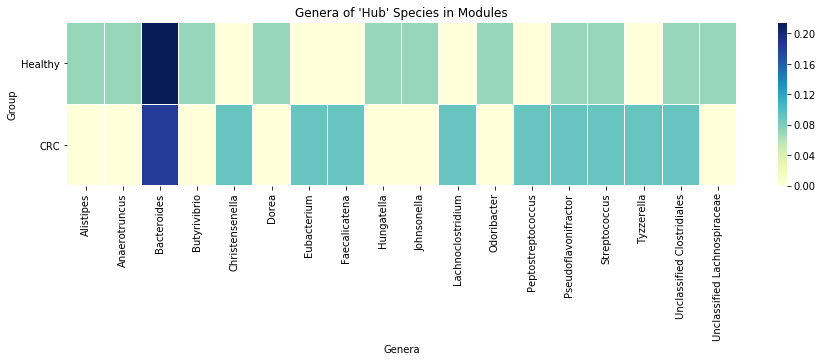

In [29]:
fig, ax = plt.subplots(figsize=(15,3))

for indexName3 in ComDegGeneraModules.columns:
        ComDegGeneraModules.rename(columns={indexName3:indexName3.replace("_"," ")}, inplace=True)
        
sns.heatmap(ComDegGeneraModules, annot=False,xticklabels=1, yticklabels=1, linewidths=.05, ax=ax, cmap="YlGnBu")
plt.title("Genera of 'Hub' Species in Modules")
plt.ylabel("Group")
plt.xlabel("Genera")
plt.yticks(rotation=0)

#plt.savefig("/home/mark/Desktop/CRCvsHealthy/Images/highDegree_Genera.png", dpi=300, bbox_inches='tight')
#plt.savefig("/home/mark/Desktop/CRCvsHealthy/Images/highDegree_Genera.svg", dpi=300, bbox_inches='tight')
#plt.savefig("/home/mark/Desktop/CRCvsHealthy/Images/highDegree_Genera.pdf", dpi=300, bbox_inches='tight')
plt.show()

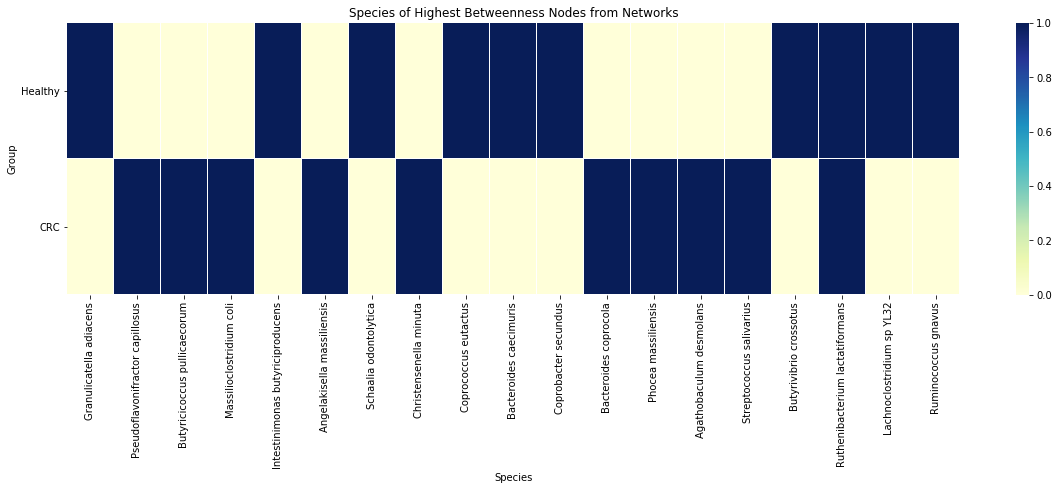

In [30]:
betSet = set(list(healthyDF[healthyDF['Negative_Edges']==0].sort_values(by='Betweenness_Centrality', ascending=False).head(10).index) + list(crcDF[crcDF['Negative_Edges']==0].sort_values(by='Betweenness_Centrality', ascending=False).head(10).index))
betNetDF = pd.DataFrame(index=betSet, columns=['Healthy','CRC']).fillna(0)
for cohort in betNetDF.columns:
    if cohort == 'Healthy':
        for x in list(healthyDF[healthyDF['Negative_Edges']==0].sort_values(by='Betweenness_Centrality', ascending=False).head(10).index):
            betNetDF.at[x,cohort] +=1
    else:
        for x in list(crcDF[crcDF['Negative_Edges']==0].sort_values(by='Betweenness_Centrality', ascending=False).head(10).index):
            betNetDF.at[x,cohort] +=1

fig, ax = plt.subplots(figsize=(20,5))
betNetDF2 = betNetDF.copy()
for indexName3 in betNetDF.index:
        betNetDF.rename(index={indexName3:indexName3.replace("_"," ")}, inplace=True)
sns.heatmap(betNetDF.T, annot=False,xticklabels=1, yticklabels=1, linewidths=.05, ax=ax, cmap="YlGnBu")
plt.title("Species of Highest Betweenness Nodes from Networks")
plt.ylabel("Group")
plt.xlabel("Species")
plt.yticks(rotation=0)
#plt.savefig("highBetweenness_Species.pdf", dpi=300, bbox_inches='tight')
plt.show()

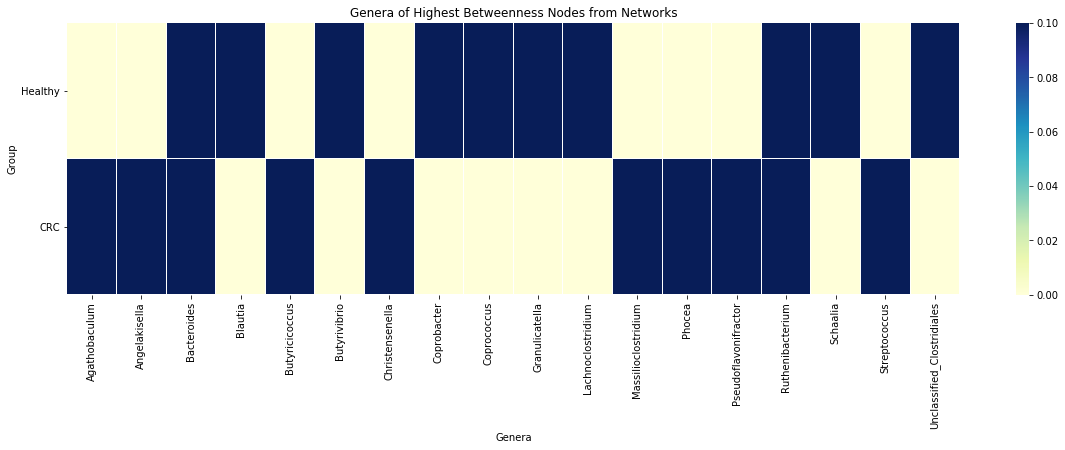

In [31]:
betNetDF2.replace(0,np.nan, inplace=True)
betNetDF2.head()
betNetGenera = inspectNodesGenusCount(betNetDF2)
betNetGenera2 = betNetGenera.div(betNetGenera.sum(axis=1), axis=0).copy()            


fig, ax = plt.subplots(figsize=(20,5))

for indexName in betNetGenera2.index:
        betNetGenera2.rename(index={indexName:indexName.replace("_"," ")}, inplace=True)
        
sns.heatmap(betNetGenera2, annot=False,xticklabels=1, yticklabels=1, linewidths=.05, ax=ax, cmap="YlGnBu")
plt.title("Genera of Highest Betweenness Nodes from Networks")
plt.ylabel("Group")
plt.xlabel("Genera")
plt.yticks(rotation=0)

#plt.savefig("highBetweenness_Genera.pdf", dpi=300, bbox_inches='tight')
plt.show()

## GRAB THE CORRECT SPECIES FUNCTIONALITY

In [32]:
def buildFunctionalDF_pfam(df, bacteriaType):
    
    df2 = df.copy()
    
    for cohort in set(list(df['Cohort'])):
        testList= [x for x in df[df['Cohort']==cohort].index]
                
        
                
        if cohort == 'Healthy':
            tempdf4 = japaneseSF_pfam.loc[testList].copy()
            tempdf4['Cohort'] = 'Healthy'
                
        elif cohort == 'CRC':
            tempdf5 = crcSF_pfam.loc[testList].copy()
            tempdf5['Cohort'] = 'CRC'
                
        else:
            continue

            
    newPfam = pd.concat([tempdf4, tempdf5])

    newPfam['Designation'] = bacteriaType
    
    return newPfam 

In [33]:
def buildFunctionalModule_pfam(df, bacteriaType):
    
    df2 = df.T.copy()
    
    df2.replace(0,np.nan, inplace=True)
    
    for cohort in list(df2.columns):
        
        testList= [x.replace(" ","_") for x in list(df2[cohort].dropna().index)]        
                
        if cohort == 'Healthy':
            tempdf4 = healthtySF_pfam.loc[testList].copy()
            tempdf4['Cohort'] = 'Healthy'
                
        elif cohort == 'CRC':
            tempdf5 = crcSF_pfam.loc[testList].copy()
            tempdf5['Cohort'] = 'CRC'
                
        else:
            continue

            
    newPfam = pd.concat([tempdf4, tempdf5])

    newPfam['Designation'] = bacteriaType
    
    return newPfam 

In [34]:
def buildFunctionalBetweenness_pfam(df, bacteriaType):
    
    df2 = df.copy()
    
    df2.replace(0,np.nan, inplace=True)
    
    for cohort in list(df2.columns):
        
        testList= [x.replace(" ","_") for x in list(df2[cohort].dropna().index)]        
                
        if cohort == 'Healthy':
            tempdf4 = healthtySF_pfam.loc[testList].copy()
            tempdf4['Cohort'] = 'Healthy'
                
        elif cohort == 'CRC':
            tempdf5 = crcSF_pfam.loc[testList].copy()
            tempdf5['Cohort'] = 'CRC'
                
        else:
            continue

            
    newPfam = pd.concat([tempdf4, tempdf5])

    newPfam['Designation'] = bacteriaType
    
    return newPfam 

In [35]:
deg = buildFunctionalModule_pfam(ComDegSpeciesModules, 'Degree')
deg2 = deg.drop(columns=['Cohort','Designation']).copy()
deg3 = deg2.copy()
for row in deg3.index:
    deg3.loc[row] = clr(np.array(deg2.loc[row].replace(0.0, 1e-10)))
deg3['Cohort'] = deg['Cohort']
deg3['Designation'] = deg['Designation']
deg3.head()

,PF06988,PF07864,PF12395,PF11859,PF18810,PF15568,PF12525,PF15922,PF04550,PF15541,...,PF12378,PF12279,PF10967,PF13802,PF00093,PF12811,PF18472,PF16439,Cohort,Designation
Bacterial_Species,,,,,,,,,,,,,,,,,,,,,
Alistipes_senegalensis,-2.270298,-2.270298,-2.270298,-2.270298,-2.270298,-2.270298,-2.270298,-2.270298,-2.270298,-2.270298,...,-2.270298,-2.270298,-2.270298,-2.270298,-2.270298,-2.270298,-2.270298,12.438764,Healthy,Degree
Anaerotruncus_colihominis,-2.411064,-2.411064,-2.411064,-2.411064,-2.411064,-2.411064,-2.411064,-2.411064,-2.411064,-2.411064,...,-2.411064,-2.411064,-2.411064,-2.411064,-2.411064,-2.411064,-2.411064,-2.411064,Healthy,Degree
Bacteroides_fluxus,-2.581420,-2.581420,-2.581420,-2.581420,-2.581420,-2.581420,-2.581420,-2.581420,-2.581420,-2.581420,...,-2.581420,-2.581420,-2.581420,11.991883,-2.581420,-2.581420,-2.581420,-2.581420,Healthy,Degree
Bacteroides_ovatus,-2.823777,-2.823777,-2.823777,-2.823777,-2.823777,-2.823777,-2.823777,-2.823777,-2.823777,-2.823777,...,-2.823777,-2.823777,-2.823777,12.977178,-2.823777,-2.823777,-2.823777,-2.823777,Healthy,Degree
Bacteroides_pectinophilus,-2.230139,-2.230139,-2.230139,-2.230139,-2.230139,-2.230139,-2.230139,-2.230139,-2.230139,-2.230139,...,-2.230139,-2.230139,-2.230139,-2.230139,-2.230139,-2.230139,-2.230139,-2.230139,Healthy,Degree


In [36]:
bet = buildFunctionalBetweenness_pfam(betNetDF, 'Betweenness')
bet2 = bet.drop(columns=['Cohort','Designation']).copy()
bet3= bet2.copy()
for row in bet3.index:
    bet3.loc[row] = clr(np.array(bet2.loc[row].replace(0.0, 1e-10)))
bet3['Cohort'] = bet['Cohort']
bet3['Designation'] = bet['Designation']
bet3.head()

,PF06988,PF07864,PF12395,PF11859,PF18810,PF15568,PF12525,PF15922,PF04550,PF15541,...,PF12378,PF12279,PF10967,PF13802,PF00093,PF12811,PF18472,PF16439,Cohort,Designation
Bacterial_Species,,,,,,,,,,,,,,,,,,,,,
Granulicatella_adiacens,-1.868661,-1.868661,-1.868661,-1.868661,-1.868661,-1.868661,-1.868661,-1.868661,-1.868661,-1.868661,...,-1.868661,-1.868661,-1.868661,-1.868661,-1.868661,-1.868661,-1.868661,-1.868661,Healthy,Betweenness
Intestinimonas_butyriciproducens,-2.383083,-2.383083,12.352727,-2.383083,-2.383083,-2.383083,-2.383083,-2.383083,-2.383083,-2.383083,...,-2.383083,-2.383083,-2.383083,-2.383083,-2.383083,-2.383083,-2.383083,-2.383083,Healthy,Betweenness
Schaalia_odontolytica,-1.912939,-1.912939,-1.912939,-1.912939,-1.912939,-1.912939,-1.912939,-1.912939,-1.912939,-1.912939,...,-1.912939,-1.912939,-1.912939,-1.912939,-1.912939,13.255044,-1.912939,-1.912939,Healthy,Betweenness
Coprococcus_eutactus,-2.214700,-2.214700,12.709170,-2.214700,-2.214700,-2.214700,-2.214700,-2.214700,-2.214700,-2.214700,...,-2.214700,-2.214700,-2.214700,12.709170,-2.214700,-2.214700,-2.214700,-2.214700,Healthy,Betweenness
Bacteroides_caecimuris,-2.591836,-2.591836,-2.591836,-2.591836,-2.591836,-2.591836,-2.591836,-2.591836,-2.591836,-2.591836,...,-2.591836,-2.591836,-2.591836,11.907664,-2.591836,-2.591836,-2.591836,-2.591836,Healthy,Betweenness


In [37]:
allFunctionNodeDF = pd.concat([deg3,bet3])

## Plot on PCA

In [38]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def runPCA(dataframe, filename, title):
    pcaDF2 = dataframe.reset_index().drop("Bacterial_Species",axis=1).copy()
    pcaDF3 = pcaDF2.drop("Cohort", axis=1).copy()
    features = pcaDF3.columns
    x = pcaDF3.loc[:, features].values
    y = pcaDF2.loc[:,['Cohort']].values
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2']).copy()
    finalDf = pd.concat([principalDf, pcaDF2[['Cohort']]], axis = 1).copy()
    import seaborn as sns
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 11.7,8.27
    palette ={'Healthy':'C2', 'CRC':'C3'}

    fig = plt.figure(figsize = (11.7,8.27))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1 ('+str("%.2f" % (100*pca.explained_variance_ratio_[0]))+"% variance)", labelpad=15)
    ax.set_ylabel('Principal Component 2 ('+str("%.2f" % (100*pca.explained_variance_ratio_[1]))+"% variance)", labelpad=15)
    ax.set_title('Principal Component Analysis ('+title+')')

    targets = ['CRC','Healthy']
    colors = ['C3','C2']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf ['Cohort'] == target
        ax.scatter(finalDf .loc[indicesToKeep, 'principal component 1']
                   , finalDf .loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , s = 50)
    ax.legend(targets, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, title='Group', prop={'size': 14})
    rcParams['figure.figsize'] = 11.7,8.27
    ax = sns.set(font_scale=1.3)
    #plt.savefig("./Files/"+filename+".pdf", bbox_inches='tight', dpi=300)
    plt.show()

In [39]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def runPCA2(dataframe, filename, title):
    pcaDF2 = dataframe.reset_index().drop("Bacterial_Species",axis=1).copy()
    pcaDF3 = pcaDF2.drop(["Cohort","Designation"], axis=1).copy()
    features = pcaDF3.columns
    x = pcaDF3.loc[:, features].values
    y = pcaDF2.loc[:,['Cohort']].values
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2']).copy()
    finalDf = pd.concat([principalDf, pcaDF2[['Cohort']]], axis = 1).copy()
    import seaborn as sns
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 11.7,8.27
    palette ={'Healthy':'C2', 'CRC':'C3'}

    fig = plt.figure(figsize = (11.7,8.27))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1 ('+str("%.2f" % (100*pca.explained_variance_ratio_[0]))+"% variance)", labelpad=15)
    ax.set_ylabel('Principal Component 2 ('+str("%.2f" % (100*pca.explained_variance_ratio_[1]))+"% variance)", labelpad=15)
    ax.set_title('Principal Component Analysis ('+title+')', y=1.03)

    targets = ['CRC','Healthy']
    colors = ['C3','C2']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf ['Cohort'] == target
        ax.scatter(finalDf .loc[indicesToKeep, 'principal component 1']
                   , finalDf .loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , s = 50, alpha=.5)
    ax.legend(targets, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, title='Group', prop={'size': 14})
    rcParams['figure.figsize'] = 11.7,8.27
    ax = sns.set(font_scale=1.3)
    #plt.savefig("./Files/"+filename+".pdf", bbox_inches='tight', dpi=300)
    plt.show()

In [40]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def runPCA3(dataframe, filename, title):
    pcaDF2 = dataframe.reset_index().drop("Bacterial_Species",axis=1).copy()
    pcaDF3 = pcaDF2.drop(["Cohort","Designation"], axis=1).copy()
    features = pcaDF3.columns
    x = pcaDF3.loc[:, features].values
    y = pcaDF2.loc[:,['Cohort']].values
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2']).copy()
    finalDf = pd.concat([principalDf, pcaDF2[['Cohort']]], axis = 1).copy()
    finalDf['Organism'] = list(dataframe.index)
    
    return(finalDf)

In [41]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pullFeatureImportance(dataframe):
    
    pcaDF2 = dataframe.reset_index().drop("Bacterial_Species",axis=1).copy()
    pcaDF3 = pcaDF2.drop(columns=["Cohort","Designation"], axis=1).copy()
    features = pcaDF3.columns
    x = pcaDF3.loc[:, features].values
    y = pcaDF2.loc[:,['Cohort','Designation']].values
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2']).copy()
    finalDf = pd.concat([principalDf, pcaDF2[['Cohort','Designation']]], axis = 1).copy()
    
    return (pd.DataFrame(pca.components_,columns=pcaDF3.columns,index = ['PC-1','PC-2']))

## Look at PCA and then look at Feature Importance

In [42]:
def pullTopFeatures(df, pc):
    tempDictionary = {"PFAM":[], "Feature_Importance":[]}
    df1 = df.copy()
    df2 = df1.T.reindex(featureImportanceDF_Pfam.T[pc].abs().sort_values(ascending=False).index).copy()
    posCount = 0
    negCount = 0
    
    for row in df2.index:
        if df2.at[row,pc] > 0 and posCount < 10:
            tempDictionary["PFAM"].append(row)
            tempDictionary["Feature_Importance"].append(df2.at[row,pc])
            posCount +=1
            
        elif df2.at[row,pc] < 0 and negCount < 10:
            tempDictionary["PFAM"].append(row)
            tempDictionary["Feature_Importance"].append(df2.at[row,pc])
            negCount +=1
        
        else:
            continue
    
    tempDF = pd.DataFrame(data=tempDictionary)
    return(tempDF.set_index("PFAM").sort_values(by="Feature_Importance", ascending=False))

## DEGREE CENTRALITY

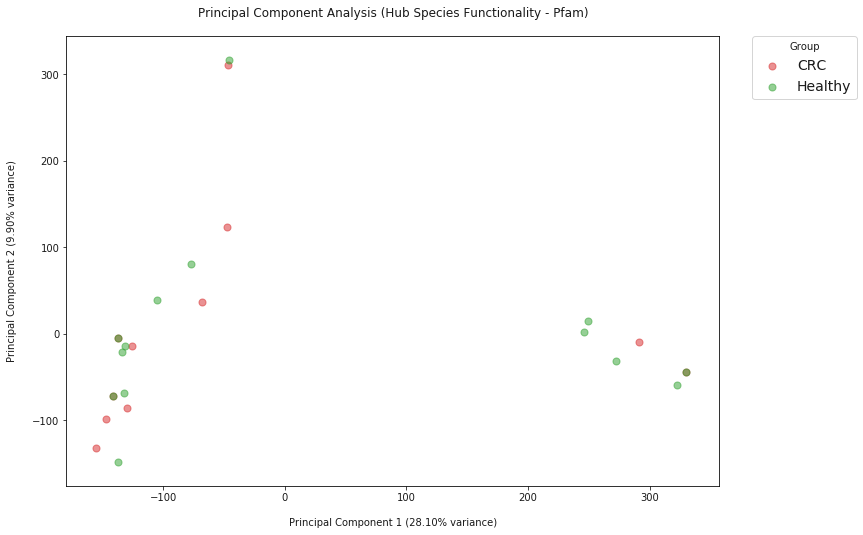

In [43]:
runPCA2(deg3, 'CRCvsHealthy/Images/Degree_all_Nodes_Pfam', 'Hub Species Functionality - Pfam')

In [44]:
degComps = runPCA3(deg3, 'ResearchForumImages/Paper3/Images/Degree_all_Nodes_Pfam', 'High Degree Centrality - Pfam')
degComps

,principal component 1,principal component 2,Cohort,Organism
0,249.545613,14.489414,Healthy,Alistipes_senegalensis
1,-132.346271,-68.566355,Healthy,Anaerotruncus_colihominis
2,330.088197,-44.580721,Healthy,Bacteroides_fluxus
3,322.658018,-59.319571,Healthy,Bacteroides_ovatus
4,-137.464480,-4.962457,Healthy,Bacteroides_pectinophilus
5,272.484726,-31.285941,Healthy,Bacteroides_salanitronis
6,-105.082399,39.057154,Healthy,Butyrivibrio_crossotus
7,-134.228690,-20.932625,Healthy,Dorea_formicigenerans
8,-136.902305,-148.261969,Healthy,Hungatella_hathewayi
9,-77.324832,80.926725,Healthy,Johnsonella_ignava


In [45]:
featureImportanceDF_Pfam = pullFeatureImportance(deg3)
degFeature1df = pullTopFeatures(featureImportanceDF_Pfam, 'PC-1')
degFeature1df

,Feature_Importance
PFAM,
PF07715,0.044684
PF00593,0.044275
PF07980,0.043922
PF14322,0.043859
PF07494,0.043264
PF13715,0.041848
PF17293,0.041260
PF16344,0.040608
PF13004,0.040585


## Betweenness Centrality

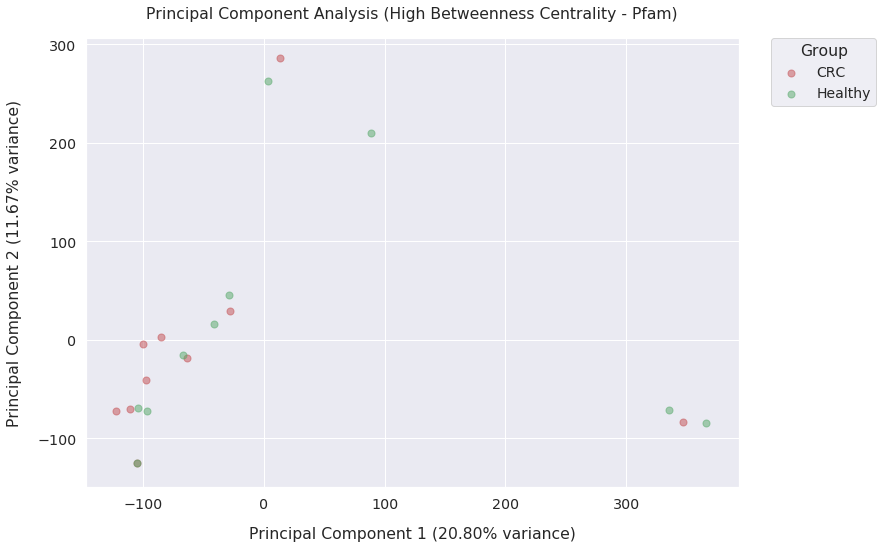

In [46]:
runPCA2(bet3, 'CRCvsHealthy/Images/Betweenness_Centrality_Nodes_Pfam', 'High Betweenness Centrality - Pfam')

In [47]:
betComps = runPCA3(bet3, 'ResearchForumImages/Paper3/Images/Degree_all_Nodes_Pfam', 'High Degree Centrality - Pfam')
betComps

,principal component 1,principal component 2,Cohort,Organism
0,3.179036,262.021941,Healthy,Granulicatella_adiacens
1,-104.079339,-69.966909,Healthy,Intestinimonas_butyriciproducens
2,88.853657,210.484584,Healthy,Schaalia_odontolytica
3,-40.813636,15.435447,Healthy,Coprococcus_eutactus
4,365.855138,-83.921740,Healthy,Bacteroides_caecimuris
5,335.699873,-72.296964,Healthy,Coprobacter_secundus
6,-28.979356,44.608263,Healthy,Butyrivibrio_crossotus
7,-104.699066,-125.297713,Healthy,Ruthenibacterium_lactatiformans
8,-96.329293,-71.335992,Healthy,Lachnoclostridium_sp_YL32
9,-67.041817,-14.488959,Healthy,Ruminococcus_gnavus


In [48]:
featureImportanceDF_Pfam = pullFeatureImportance(bet3)
betFeature1df = pullTopFeatures(featureImportanceDF_Pfam, 'PC-1')
betFeature1df

,Feature_Importance
PFAM,
PF07715,0.040547
PF13715,0.040352
PF07494,0.040161
PF00593,0.039871
PF14322,0.039655
PF07980,0.039652
PF06826,0.038427
PF03993,0.037978
PF17293,0.037767


## Compare functional Distance to Association Strength

In [49]:
#Healthy Only
healthyEdgeDF_trimmed = pd.read_csv("./Files/Dataframes/OnlyHealthy_Associations.csv").set_index("Unnamed: 0").drop(columns=['CRC'])
healthyEdgeDF_trimmed.index.name='Associations'
healthyEdgeDF_trimmed.head()

,Healthy
Associations,
Eubacterium_ventriosum<-->Lactobacillus_rogosae,0.054469
Eubacterium_eligens<-->Lactobacillus_rogosae,0.109550
Holdemania_massiliensis<-->Johnsonella_ignava,0.062154
Johnsonella_ignava<-->Ruminococcus_bicirculans,0.042038
Bacteroides_cellulosilyticus<-->Butyricimonas_faecalis,0.102276


In [50]:
#CRC Only
crcEdgeDF_trimmed = pd.read_csv("./Files/Dataframes/OnlyCRC_associations.csv").set_index("Unnamed: 0")
crcEdgeDF_trimmed.index.name='Associations'
crcEdgeDF_trimmed.head()

,CRC
Associations,
Clostridiales_bacterium_CCNA10<-->Ruthenibacterium_lactatiformans,0.028941
Angelakisella_massiliensis<-->Clostridiales_bacterium_CCNA10,0.023563
Butyricicoccus_pullicaecorum<-->Clostridiales_bacterium_CCNA10,0.068957
Clostridiales_bacterium_CCNA10<-->Johnsonella_ignava,-0.010335
Clostridiales_bacterium_CCNA10<-->Flavonifractor_plautii,0.043787


In [51]:
crcNetwork_trim = crcNetwork.copy()
for edge in crcNetwork.edges():
    if str(edge[0])+"<-->"+str(edge[1]) not in list(crcEdgeDF_trimmed.index) and str(edge[1])+"<-->"+str(edge[0]) not in list(crcEdgeDF_trimmed.index):
        crcNetwork_trim.remove_edge(edge[0],edge[1])
print(len(crcNetwork_trim.edges()))

234


In [52]:
healthyNetwork_trim = healthyNetwork.copy()
for edge in healthyNetwork.edges():
    if str(edge[0])+"<-->"+str(edge[1]) not in list(healthyEdgeDF_trimmed.index) and str(edge[1])+"<-->"+str(edge[0]) not in list(healthyEdgeDF_trimmed.index):
        healthyNetwork_trim.remove_edge(edge[0],edge[1])
print(len(healthyNetwork_trim.edges()))

202


In [53]:
#ALL FUNCTION
from scipy.spatial import distance
def pullWeightDistance(network, cohortName, functionalDF):
    tempDict = {"Association_Weight":[], "Functional_Distance_Pfam":[], "Cohort":[]}
    for i in list(network.edges(data='weight')):
        tempDict['Association_Weight'].append(float(i[2]))
        tempDict['Functional_Distance_Pfam'].append(float(distance.braycurtis(np.array(functionalDF.loc[i[0].replace(",","").replace("(","").replace(")","")]), np.array(functionalDF.loc[i[1].replace(",","").replace("(","").replace(")","")]))))
        tempDict['Cohort'].append(cohortName)
    tempDF = pd.DataFrame(data=tempDict)
    return(tempDF)

In [54]:
#ALL FUNCTION
from skbio.stats.composition import clr
from scipy.spatial import distance
def pullWeightDistanceCLR(network, cohortName, functionalDF):
    tempDict = {"Association_Weight":[], "Functional_Distance_Pfam":[], "Cohort":[]}
    for i in list(network.edges(data='weight')):
        tempDict['Association_Weight'].append(float(i[2]))
        tempDict['Functional_Distance_Pfam'].append(float(distance.euclidean(clr(np.array(functionalDF.loc[i[0].replace(",","").replace("(","").replace(")","")].replace(0.0, 1e-10))), clr(np.array(functionalDF.loc[i[1].replace(",","").replace("(","").replace(")","")].replace(0.0, 1e-10))))))
        tempDict['Cohort'].append(cohortName)
    tempDF = pd.DataFrame(data=tempDict)
    return(tempDF)

In [55]:
#Bray-Curtis

healthyFunctTrimmed = pullWeightDistance(healthyNetwork_trim, 'Healthy Only', healthtySF_pfam)
crcFunctTrimmed = pullWeightDistance(crcNetwork_trim, 'CRC Only', crcSF_pfam)

crcfunctWeightDF = pullWeightDistance(crcNetwork, 'CRC', crcSF_pfam)
healthyfunctWeightDF = pullWeightDistance(healthyNetwork, 'Healthy', healthtySF_pfam)


allFuntWeightDF = pd.concat([healthyfunctWeightDF,crcfunctWeightDF])
allFuntWeightDF_andTrim = pd.concat([healthyfunctWeightDF,crcfunctWeightDF,crcFunctTrimmed])
allFuntWeightDF_andHTrim = pd.concat([healthyfunctWeightDF,crcfunctWeightDF,healthyFunctTrimmed])


allFuntWeightDF_andTrim.rename(columns={'Cohort':"Group"}, inplace=True)
allFuntWeightDF_andHTrim.rename(columns={'Cohort':"Group"}, inplace=True)
allFuntWeightDF.rename(columns={'Cohort':"Group"}, inplace=True)

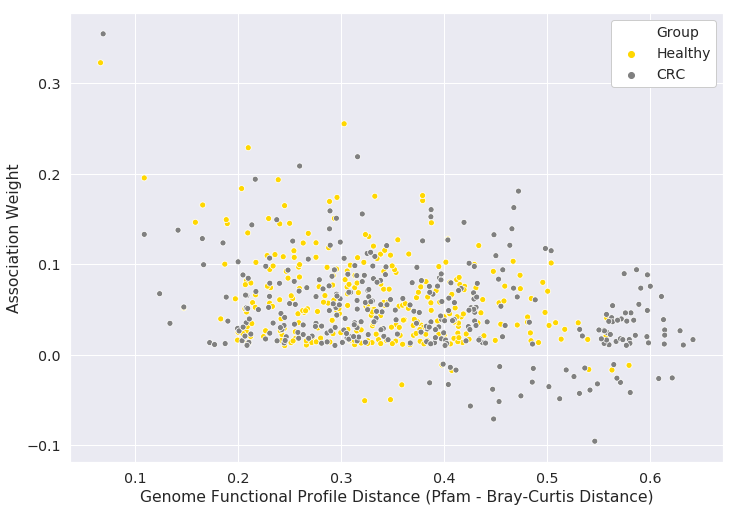

In [56]:
from matplotlib import rcParams
sns.set(font_scale=1.3)
rcParams['figure.figsize'] = 11.7,8.27
palette ={"CRC":"grey",'Healthy':'gold'}
sns.scatterplot(data=allFuntWeightDF, x='Functional_Distance_Pfam', y='Association_Weight', hue='Group',palette=palette)

legend = plt.legend(frameon = 1, framealpha=1, prop={'size': 14})
frame = legend.get_frame()
frame.set_facecolor('white')

plt.xlabel("Genome Functional Profile Distance (Pfam - Bray-Curtis Distance)")
plt.ylabel("Association Weight")
#plt.savefig("AssociationWeightvsFunctionalDistance_Bray.pdf", bbox_inches='tight', dpi=300)
plt.show()

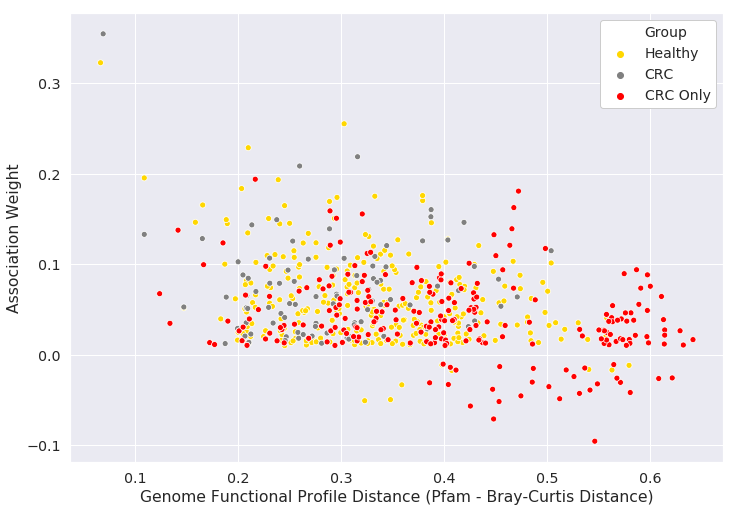

In [57]:
from matplotlib import rcParams
sns.set(font_scale=1.3)
rcParams['figure.figsize'] = 11.7,8.27
palette ={"CRC":"grey",'Healthy':'gold', 'CRC Only':'red'}
sns.scatterplot(data=allFuntWeightDF_andTrim, x='Functional_Distance_Pfam', y='Association_Weight', hue='Group',palette=palette)

legend = plt.legend(frameon = 1, framealpha=1, prop={'size': 14})
frame = legend.get_frame()
frame.set_facecolor('white')

plt.xlabel("Genome Functional Profile Distance (Pfam - Bray-Curtis Distance)")
plt.ylabel("Association Weight")
#plt.savefig("AssociationWeightvsFunctionalDistance_CRCONlyBray.pdf", bbox_inches='tight', dpi=300)
plt.show()

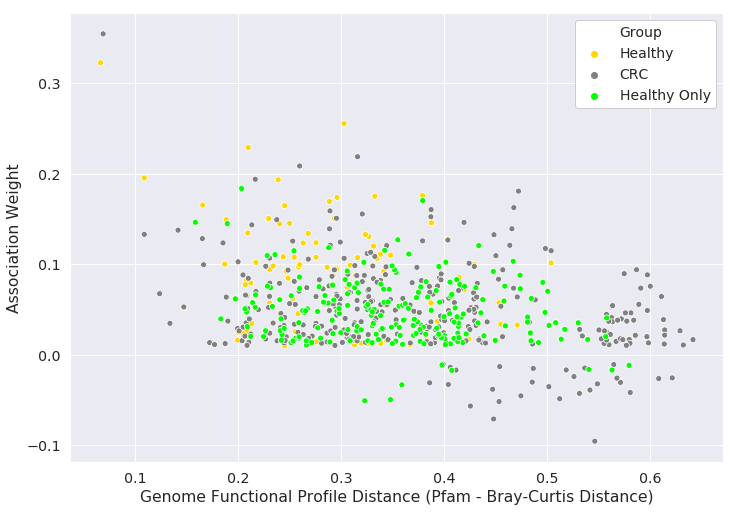

In [58]:
from matplotlib import rcParams
sns.set(font_scale=1.3)
rcParams['figure.figsize'] = 11.7,8.27
palette ={"CRC":"grey",'Healthy':'gold', 'Healthy Only':'lime'}
sns.scatterplot(data=allFuntWeightDF_andHTrim, x='Functional_Distance_Pfam', y='Association_Weight', hue='Group',palette=palette)

legend = plt.legend(frameon = 1, framealpha=1, prop={'size': 14})
frame = legend.get_frame()
frame.set_facecolor('white')

plt.xlabel("Genome Functional Profile Distance (Pfam - Bray-Curtis Distance)")
plt.ylabel("Association Weight")
#plt.savefig("AssociationWeightvsFunctionalDistance_HealthyOnlyBray.pdf", bbox_inches='tight', dpi=300)
plt.show()

## Now Look at Designated Node Partner Functionalities

In [59]:
def labelModules(partition, cohort):
    tempDict = {}
    countt = 0
    for i in partition:
        if len(i) > 2:
            tempDict[cohort+"_Module_"+str(countt)] = i
            countt +=1
        
    return (tempDict)

In [60]:
crcModuleLabel = labelModules(crcPartitions, "CRC")
healthyModuleLabel = labelModules(healthyPartitions, "Healthy")

In [61]:
def buildCommunityNodes(comList, cohortFunctionality, cohortName):
    
    tempDF = pd.DataFrame(columns=cohortFunctionality.columns)
    
    i = 0
    for module in list(comList.keys()):
        tempDF.loc[module] = cohortFunctionality.loc[comList[module]].sum().copy()
        i+=1
    
    tempDF['Cohort'] = cohortName
    
    return tempDF

In [62]:
def buildWeightedModuleNodes(comList, cohortFunctionality, cohortAbundance, cohortName):
    
    tempDF = pd.DataFrame(columns=cohortFunctionality.columns, index=list(comList.keys()))
    tempDF.fillna(0.0, inplace=True)
    
    for module in comList:
        summ = 0.0
        tempDict = {}
        
        for species in comList[module]:
            tempDict[species] = cohortAbundance[species].mean()
            summ += cohortAbundance[species].mean()
        
        for bacteria in comList[module]:
            tempDF.loc[module] += (cohortFunctionality.loc[bacteria]) * (tempDict[bacteria]/summ)
    
    tempDF['Cohort'] = cohortName
    
    return tempDF

In [63]:
healthySpeciesALLDF = pd.read_csv("./Files/Dataframes/speciesDataframes/masterJapanese_allSpecies.csv").set_index("SampleName")
crcSpeciesALLDF = pd.read_csv("./Files/Dataframes/speciesDataframes/masterCRC_allSpecies.csv").set_index("SampleName")

healthySpeciesALLDF.replace(0.0, np.nan, inplace=True)
crcSpeciesALLDF.replace(0.0, np.nan, inplace=True)

In [64]:
crcModules = buildWeightedModuleNodes(crcModuleLabel, crcSF_pfam, crcSpeciesALLDF, 'CRC')
healthyModules = buildWeightedModuleNodes(healthyModuleLabel, healthtySF_pfam, healthySpeciesALLDF, 'Healthy')

In [65]:
healthyModuleLabel

{'Healthy_Module_0': {'Bacteroides_barnesiae',
  'Bacteroides_helcogenes',
  'Bacteroides_salanitronis',
  'Coprobacter_fastidiosus',
  'Culturomica_massiliensis',
  'Mediterranea_massiliensis',
  'Paraprevotella_xylaniphila',
  'Prevotellamassilia_timonensis'},
 'Healthy_Module_1': {'Holdemania_massiliensis',
  'Johnsonella_ignava',
  'Ruminococcus_bicirculans'},
 'Healthy_Module_2': {'Anaerotruncus_colihominis',
  'Angelakisella_massiliensis',
  'Blautia_schinkii',
  'Clostridium_symbiosum',
  'Lactonifactor_longoviformis',
  'Traorella_massiliensis'},
 'Healthy_Module_3': {'Butyrivibrio_crossotus',
  'Clostridium_sporogenes',
  'Coprococcus_eutactus',
  'Eubacterium_eligens',
  'Eubacterium_ventriosum',
  'Lactobacillus_rogosae',
  'Marvinbryantia_formatexigens',
  'Monoglobus_pectinilyticus'},
 'Healthy_Module_4': {'Granulicatella_adiacens',
  'Streptococcus_mitis',
  'Streptococcus_sp_oral_taxon_431'},
 'Healthy_Module_5': {'Streptococcus_parasanguinis',
  'Streptococcus_salivariu

In [66]:
crcModuleLabel

{'CRC_Module_0': {'Dialister_pneumosintes',
  'Gemella_morbillorum',
  'Parvimonas_micra',
  'Peptostreptococcus_stomatis'},
 'CRC_Module_1': {'Bacteroides_barnesiae',
  'Bacteroides_coprophilus',
  'Bacteroides_fluxus',
  'Bacteroides_helcogenes',
  'Bacteroides_plebeius',
  'Mediterranea_massiliensis',
  'Paraprevotella_xylaniphila'},
 'CRC_Module_2': {'Granulicatella_adiacens',
  'Streptococcus_mitis',
  'Streptococcus_parasanguinis',
  'Streptococcus_sp_A12',
  'Streptococcus_sp_oral_taxon_431'},
 'CRC_Module_3': {'Angelakisella_massiliensis',
  'Bacteroides_cellulosilyticus',
  'Butyricicoccus_pullicaecorum',
  'Clostridium_phoceensis',
  'Emergencia_timonensis',
  'Fournierella_massiliensis',
  'Gemmiger_formicilis',
  'Intestinimonas_butyriciproducens',
  'Lachnoclostridium_phocaeense',
  'Merdimonas_faecis',
  'Odoribacter_splanchnicus',
  'Oscillibacter_sp_PEA192',
  'Pseudoflavonifractor_capillosus',
  'Subdoligranulum_variabile'},
 'CRC_Module_4': {'Bariatricus_massiliensis'

In [67]:
#Unweighted version
#crcModules = buildCommunityNodes(crcModuleLabel, crcSF_pfam, 'CRC')
#healthyModules = buildCommunityNodes(healthyModuleLabel, healthtySF_pfam, 'Healthy')

In [68]:
allModules = pd.concat([crcModules,healthyModules])
#Label the index so the PCA code doesnt have to be changed. Im lazy I know. 
allModules.index.name = 'Bacterial_Species'
allMDF1 = allModules.copy()
allMDF2 = allMDF1.drop(columns=['Cohort']).copy()
allMDF2.replace(0.0, np.nan, inplace=True)
allMDF2.dropna(axis=1, thresh=1, inplace=True)
allMDF2.fillna(0.0, inplace=True)
allMDF3 = allMDF2.copy()

for row in allMDF3.index:
    allMDF3.loc[row] = clr(np.array(allMDF2.loc[row].replace(0.0, 1e-10)))
allMDF3['Cohort'] = allMDF1['Cohort']
allMDF3.head()

,PF12395,PF18810,PF03118,PF00701,PF17866,PF11185,PF15565,PF14437,PF13493,PF02595,...,PF01862,PF06831,PF05609,PF06574,PF01018,PF00793,PF13802,PF12811,PF16439,Cohort
Bacterial_Species,,,,,,,,,,,,,,,,,,,,,
CRC_Module_0,-5.784876,-5.784876,9.584050,9.625276,8.553363,-5.784876,-5.784876,9.584050,-5.784876,7.714549,...,-5.784876,7.714549,-5.784876,9.584050,9.584050,9.235184,-5.784876,-5.784876,-5.784876,CRC
CRC_Module_1,-6.873267,-6.873267,8.509336,8.692883,7.525416,3.052558,-6.873267,7.753238,-6.873267,7.584037,...,-6.873267,-6.873267,-6.873267,7.753238,7.753238,8.446386,8.155781,-6.873267,-6.873267,CRC
CRC_Module_2,-5.594297,-5.594297,9.565016,10.206770,8.916723,6.918341,-5.594297,9.565016,-5.594297,9.491492,...,-5.594297,9.491492,-5.594297,9.565016,9.565016,9.649485,-5.594297,-5.594297,-5.594297,CRC
CRC_Module_3,4.312704,2.554792,4.772423,5.596504,4.961917,4.300655,-9.953467,4.731724,4.937915,3.909260,...,-9.953467,0.123412,-9.953467,4.731724,4.731724,5.363410,4.613485,-9.953467,-9.953467,CRC
CRC_Module_4,-7.021512,-7.021512,8.017793,8.615902,5.211709,5.211709,-7.021512,7.714671,8.113008,7.714671,...,-7.021512,6.056022,-7.021512,7.714671,7.714671,7.955449,5.211709,-7.021512,-7.021512,CRC


In [69]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def runPCA(dataframe, filename, title):
    pcaDF2 = dataframe.reset_index().drop("Bacterial_Species",axis=1).copy()
    pcaDF3 = pcaDF2.drop("Cohort", axis=1).copy()
    features = pcaDF3.columns
    x = pcaDF3.loc[:, features].values
    y = pcaDF2.loc[:,['Cohort']].values
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2']).copy()
    finalDf = pd.concat([principalDf, pcaDF2[['Cohort']]], axis = 1).copy()
    import seaborn as sns
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 11.7,8.27
    palette ={"Healthy":'green', "CRC":'red'}

    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1 ('+str("%.2f" % (100*pca.explained_variance_ratio_[0]))+"% variance)", labelpad=15)
    ax.set_ylabel('Principal Component 2 ('+str("%.2f" % (100*pca.explained_variance_ratio_[1]))+"% variance)", labelpad=15)
    ax.set_title('Principal Component Analysis ('+title+')')

    targets = ['Healthy','CRC']

    colors = ['gold','grey']
    
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf ['Cohort'] == target
        ax.scatter(finalDf .loc[indicesToKeep, 'principal component 1']
                   , finalDf .loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , s = 50)
    ax.legend(targets, facecolor='white', borderaxespad=0, title='Group')
    rcParams['figure.figsize'] = 11.7,12.27
    ax = sns.set(font_scale=1.5)
    #plt.savefig("./Files/"+filename+".pdf", dpi=300, bbox_inches='tight')
    plt.show()

In [70]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def runPCA2(dataframe, filename, title):
    pcaDF2 = dataframe.reset_index().drop("Bacterial_Species",axis=1).copy()
    pcaDF3 = pcaDF2.drop(["Cohort","Designation"], axis=1).copy()
    features = pcaDF3.columns
    x = pcaDF3.loc[:, features].values
    y = pcaDF2.loc[:,['Cohort']].values
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2']).copy()
    finalDf = pd.concat([principalDf, pcaDF2[['Cohort']]], axis = 1).copy()
    import seaborn as sns
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 11.7,8.27
    palette ={"Healthy":'green', "CRC":'red'}

    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1 ('+str("%.2f" % (100*pca.explained_variance_ratio_[0]))+"% variance)", labelpad=15)
    ax.set_ylabel('Principal Component 2 ('+str("%.2f" % (100*pca.explained_variance_ratio_[1]))+"% variance)", labelpad=15)
    ax.set_title('Principal Component Analysis ('+title+')', y=1.03)

    targets = ['Healthy','CRC']

    colors = ['gold','grey']
    
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf ['Cohort'] == target
        ax.scatter(finalDf .loc[indicesToKeep, 'principal component 1']
                   , finalDf .loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , s = 50, alpha=.5)
    ax.legend(targets, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, title='Cohorts')
    rcParams['figure.figsize'] = 11.7,12.27
    ax = sns.set(font_scale=1.5)
    #plt.savefig("./Files/"+filename+".pdf", dpi=300, bbox_inches='tight')
    plt.show()

In [71]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pullFeatureImportance(dataframe):
    
    pcaDF2 = dataframe.reset_index().drop("Bacterial_Species",axis=1).copy()
    pcaDF3 = pcaDF2.drop(columns=["Cohort"], axis=1).copy()
    features = pcaDF3.columns
    x = pcaDF3.loc[:, features].values
    y = pcaDF2.loc[:,['Cohort']].values
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2']).copy()
    finalDf = pd.concat([principalDf, pcaDF2[['Cohort']]], axis = 1).copy()
    
    return (pd.DataFrame(pca.components_,columns=pcaDF3.columns,index = ['PC-1','PC-2']))

In [72]:
def pullTopFeatures(df, pc):
    tempDictionary = {"PFAM":[], "Feature_Importance":[]}
    df1 = df.copy()
    df2 = df1.T.reindex(featureImportanceDF_TIGRFAM.T[pc].abs().sort_values(ascending=False).index).copy()
    posCount = 0
    negCount = 0
    
    for row in df2.index:
        if df2.at[row,pc] > 0 and posCount < 10:
            tempDictionary["PFAM"].append(row)
            tempDictionary["Feature_Importance"].append(df2.at[row,pc])
            posCount +=1
            
        elif df2.at[row,pc] < 0 and negCount < 10:
            tempDictionary["PFAM"].append(row)
            tempDictionary["Feature_Importance"].append(df2.at[row,pc])
            negCount +=1
        
        else:
            continue
    
    tempDF = pd.DataFrame(data=tempDictionary)
    return(tempDF.set_index("PFAM").sort_values(by="Feature_Importance", ascending=False))

In [73]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pullNodeArea(dataframe):
    
    pcaDF2 = dataframe.reset_index().drop("Bacterial_Species",axis=1).copy()
    pcaDF3 = pcaDF2.drop(columns=["Cohort","Designation"], axis=1).copy()
    features = pcaDF3.columns
    x = pcaDF3.loc[:, features].values
    y = pcaDF2.loc[:,['Cohort','Designation']].values
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2']).copy()
    finalDf = pd.concat([principalDf, pcaDF2[['Cohort','Designation']]], axis = 1).copy()
    
    tempDict = {"Bacterial_Species":[], "Cohort":[], "PC1":[], "PC2":[]}
    
    for x in finalDf.index:
        tempDict['Bacterial_Species'].append(list(dataframe.index)[x])
        tempDict['Cohort'].append(finalDf.at[x,'Cohort'])
        tempDict['PC1'].append(finalDf.at[x,'principal component 1'])
        tempDict['PC2'].append(finalDf.at[x,'principal component 2'])
    
    
    tempDF = pd.DataFrame(data=tempDict).set_index("Bacterial_Species")
    
    tempDict2 = {"Cohort":[], "LeftSide":[], "RightSide":[]}
    
    for y in list(set(tempDF['Cohort'])):
        tempDict2['Cohort'].append(y)
        tempDict2['LeftSide'].append(len([i for i in list(tempDF[tempDF["Cohort"]==y]['PC1']) if i < 0]))
        tempDict2['RightSide'].append(len([i for i in list(tempDF[tempDF["Cohort"]==y]['PC1']) if i > 0]))
    
    tempDF2 = pd.DataFrame(data=tempDict2).set_index("Cohort")
    
    return tempDF2

In [74]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pullNodeModuleArea(dataframe):
    
    pcaDF2 = dataframe.reset_index().drop("Bacterial_Species",axis=1).copy()
    pcaDF3 = pcaDF2.drop(columns=["Cohort"], axis=1).copy()
    features = pcaDF3.columns
    x = pcaDF3.loc[:, features].values
    y = pcaDF2.loc[:,['Cohort']].values
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2']).copy()
    finalDf = pd.concat([principalDf, pcaDF2[['Cohort']]], axis = 1).copy()
    
    tempDict = {"Bacterial_Species":[], "PC1":[], "PC2":[]}
    
    for x in finalDf.index:
        tempDict['Bacterial_Species'].append(list(dataframe.index)[x])
        tempDict['PC1'].append(finalDf.at[x,'principal component 1'])
        tempDict['PC2'].append(finalDf.at[x,'principal component 2'])
    
    tempDF = pd.DataFrame(data=tempDict).set_index("Bacterial_Species")

    tempDict2 = {"Module":[], "Left_Cluster":[], "Right_Cluster":[], "Top_Cluster":[], "Bottom_Cluster":[]}
    
    for y in tempDF.index:
        tempDict2['Module'].append(y)
        if float(tempDF.at[y,'PC2']) > 100:
            tempDict2['Top_Cluster'].append(1)
            tempDict2['Left_Cluster'].append(np.nan)
            tempDict2['Right_Cluster'].append(np.nan)
            tempDict2['Bottom_Cluster'].append(np.nan)
        elif float(tempDF.at[y,'PC2']) < 50 and float(tempDF.at[y,'PC1']) < -90: 
            tempDict2['Top_Cluster'].append(np.nan)
            tempDict2['Left_Cluster'].append(1)
            tempDict2['Right_Cluster'].append(np.nan)
            tempDict2['Bottom_Cluster'].append(np.nan)
        elif float(tempDF.at[y,'PC2']) < -80 and float(tempDF.at[y,'PC1']) > -90: 
            tempDict2['Top_Cluster'].append(np.nan)
            tempDict2['Left_Cluster'].append(np.nan)
            tempDict2['Right_Cluster'].append(np.nan)
            tempDict2['Bottom_Cluster'].append(1)
        else:
            tempDict2['Top_Cluster'].append(np.nan)
            tempDict2['Left_Cluster'].append(np.nan)
            tempDict2['Right_Cluster'].append(1)
            tempDict2['Bottom_Cluster'].append(np.nan)
    
    tempDF2 = pd.DataFrame(data=tempDict2).set_index("Module")
    
    return tempDF2

In [75]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pullNodeModuleArea_5Clusters(dataframe):
    
    pcaDF2 = dataframe.reset_index().drop("Bacterial_Species",axis=1).copy()
    pcaDF3 = pcaDF2.drop(columns=["Cohort"], axis=1).copy()
    features = pcaDF3.columns
    x = pcaDF3.loc[:, features].values
    y = pcaDF2.loc[:,['Cohort']].values
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2']).copy()
    finalDf = pd.concat([principalDf, pcaDF2[['Cohort']]], axis = 1).copy()
    
    tempDict = {"Bacterial_Species":[], "PC1":[], "PC2":[]}
    
    for x in finalDf.index:
        tempDict['Bacterial_Species'].append(list(dataframe.index)[x])
        tempDict['PC1'].append(finalDf.at[x,'principal component 1'])
        tempDict['PC2'].append(finalDf.at[x,'principal component 2'])
    
    tempDF = pd.DataFrame(data=tempDict).set_index("Bacterial_Species")

    tempDict2 = {"Module":[], "Cluster_1":[], "Cluster_2":[], "Cluster_3":[], "Cluster_4":[], "Cluster_5":[]}
    
    for y in tempDF.index:
        tempDict2['Module'].append(y)
        if float(tempDF.at[y,'PC2']) < 0 and float(tempDF.at[y,'PC1']) < -100:
            tempDict2['Cluster_1'].append(1)
            tempDict2['Cluster_2'].append(np.nan)
            tempDict2['Cluster_3'].append(np.nan)
            tempDict2['Cluster_4'].append(np.nan)
            tempDict2['Cluster_5'].append(np.nan)
        elif float(tempDF.at[y,'PC2']) > 100 and float(tempDF.at[y,'PC2']) < 250 and float(tempDF.at[y,'PC1']) < -100: 
            tempDict2['Cluster_1'].append(np.nan)
            tempDict2['Cluster_2'].append(1)
            tempDict2['Cluster_3'].append(np.nan)
            tempDict2['Cluster_4'].append(np.nan)
            tempDict2['Cluster_5'].append(np.nan)
        elif float(tempDF.at[y,'PC2']) > 250: 
            tempDict2['Cluster_1'].append(np.nan)
            tempDict2['Cluster_2'].append(np.nan)
            tempDict2['Cluster_3'].append(1)
            tempDict2['Cluster_4'].append(np.nan)
            tempDict2['Cluster_5'].append(np.nan)
        elif float(tempDF.at[y,'PC1']) > 200:
            tempDict2['Cluster_1'].append(np.nan)
            tempDict2['Cluster_2'].append(np.nan)
            tempDict2['Cluster_3'].append(np.nan)
            tempDict2['Cluster_4'].append(1)
            tempDict2['Cluster_5'].append(np.nan)
        else:
            tempDict2['Cluster_1'].append(np.nan)
            tempDict2['Cluster_2'].append(np.nan)
            tempDict2['Cluster_3'].append(np.nan)
            tempDict2['Cluster_4'].append(np.nan)
            tempDict2['Cluster_5'].append(1)
    
    tempDF2 = pd.DataFrame(data=tempDict2).set_index("Module")
    
    return tempDF2

## LOOK AT PCA

In [76]:
moduelClusterDF = pullNodeModuleArea_5Clusters(allMDF3)
moduelClusterDF.to_csv("./Files/Networks/Modules/ModuleCluster_df.csv")


import dill
import pickle
f = open("./Files/Networks/Modules/Healthy_modules.pkl","wb")
pickle.dump(healthyModuleLabel,f)
f.close()

f = open("./Files/Networks/Modules/CRC_modules.pkl","wb")
pickle.dump(crcModuleLabel,f)
f.close()

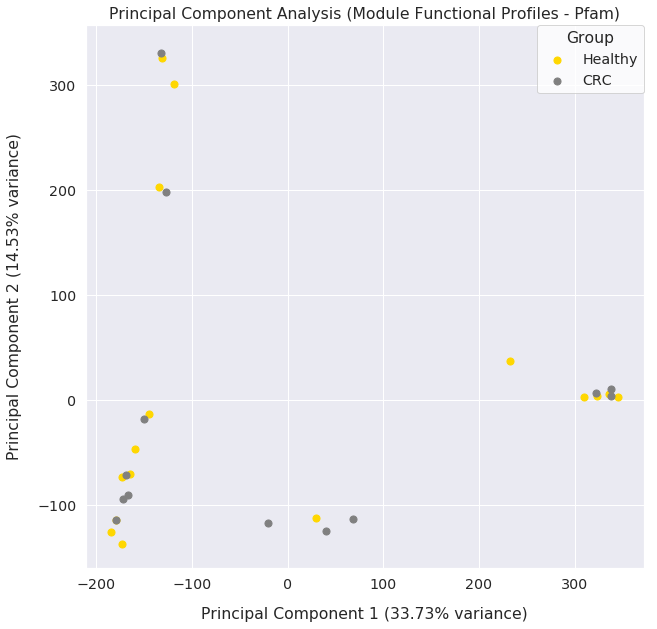

In [77]:
runPCA(allMDF3, 'CRCvsHealthy/Images/PFAMMODULES', 'Module Functional Profiles - Pfam')

In [78]:
tempDf = allMDF3.copy()
tempDf['Designation']='Temp'

In [79]:
tempcomp = runPCA3(tempDf, 'Degree_all_Nodes_Pfam', 'High Degree Centrality - Pfam')
tempcomp.sort_values(by='principal component 1', ascending=False)

,principal component 1,principal component 2,Cohort,Organism
22,345.788069,3.192857,Healthy,Healthy_Module_9
10,338.369445,3.982572,CRC,CRC_Module_10
9,338.117223,10.384832,CRC,CRC_Module_9
28,336.232274,6.059837,Healthy,Healthy_Module_15
19,322.863829,3.574507,Healthy,Healthy_Module_6
1,321.903995,7.229735,CRC,CRC_Module_1
13,310.224125,2.913144,Healthy,Healthy_Module_0
24,232.439385,37.449374,Healthy,Healthy_Module_11
5,68.700480,-113.199706,CRC,CRC_Module_5
3,39.957428,-124.528872,CRC,CRC_Module_3


## Cluster Module Functional Profiles

## KMeans

In [80]:
pcaClusterDF = tempcomp.set_index("Organism").drop(columns=['Cohort']).copy()

For n_clusters = 2 The average silhouette_score is : 0.638375628327044
For n_clusters = 3 The average silhouette_score is : 0.7523135528135256
For n_clusters = 4 The average silhouette_score is : 0.7914649394479921
For n_clusters = 5 The average silhouette_score is : 0.8073092420070688
For n_clusters = 6 The average silhouette_score is : 0.7313974895016278


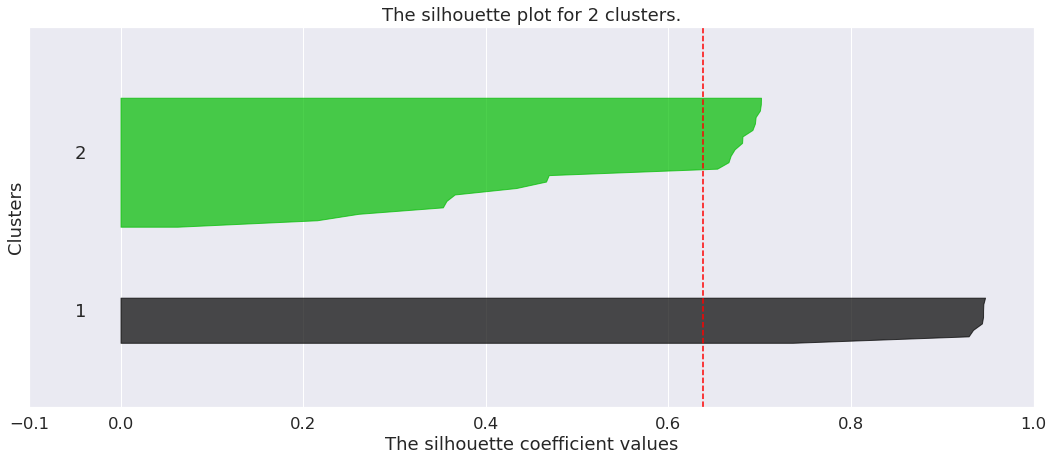

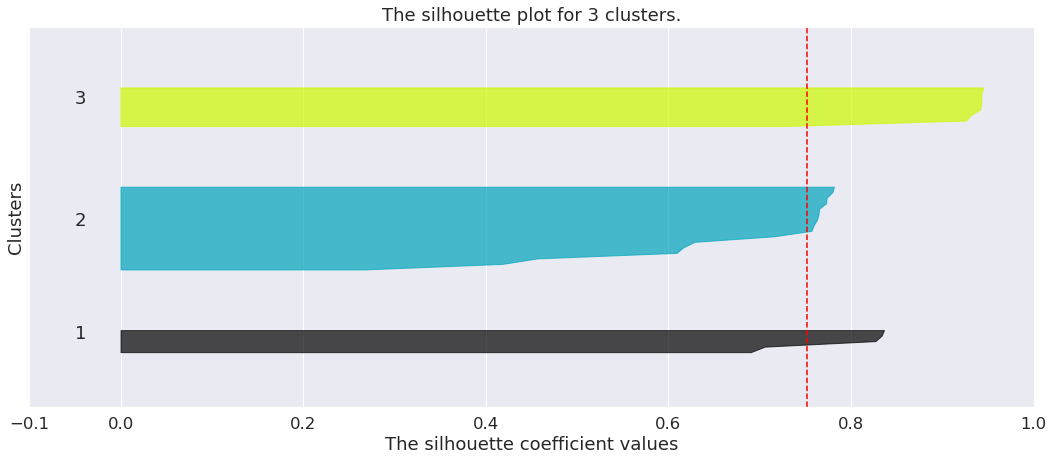

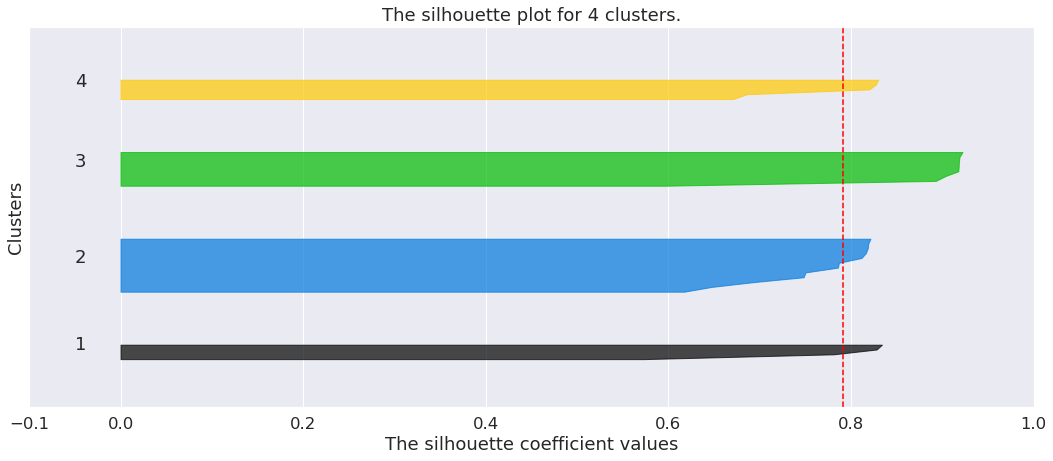

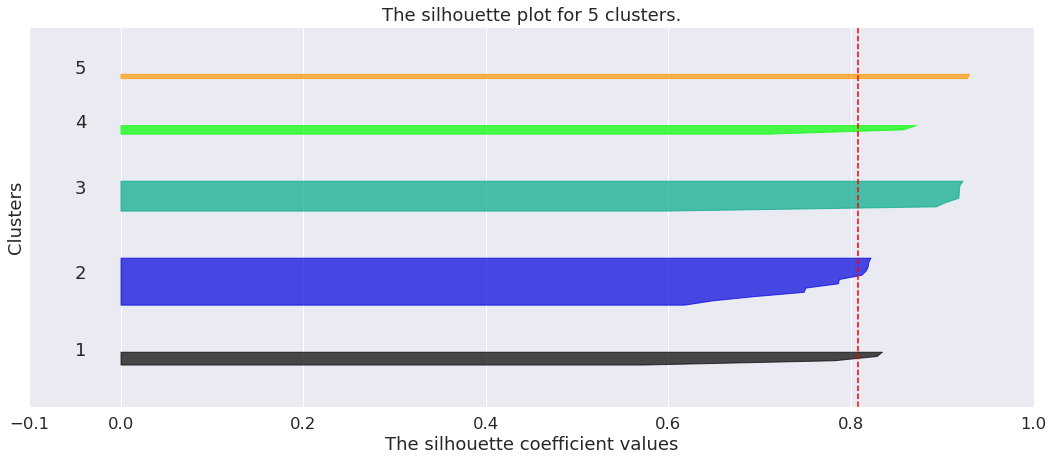

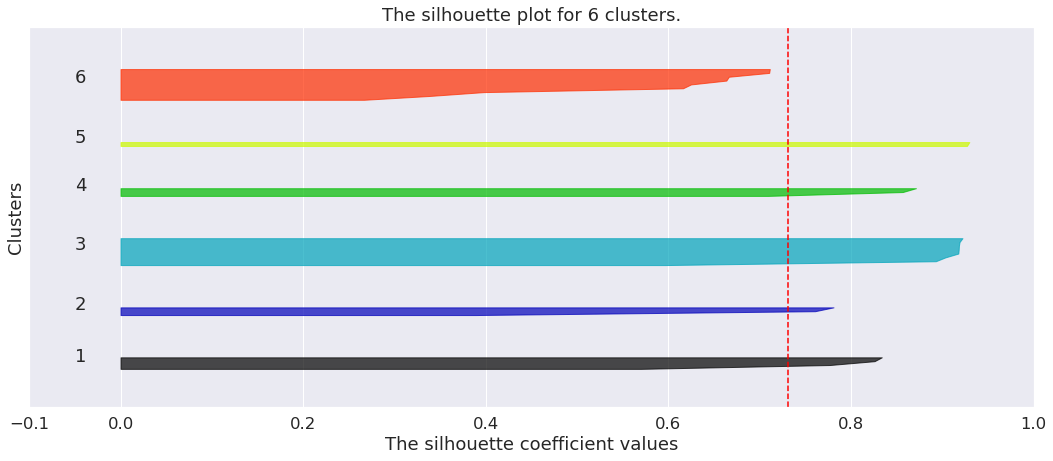

In [81]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import matplotlib.cm as cm

range_n_clusters = [2, 3, 4, 5, 6]

X = pcaClusterDF.copy()

KScores = {}
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    KScores[n_clusters]=silhouette_avg
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for "+str(i+1)+" clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Clusters")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    #plt.savefig("Silhouette_PCA_Modules_"+str(i)+".pdf", bbox_inches='tight', dpi=300)

plt.show()



([<matplotlib.axis.XTick at 0x7f81d26a6898>,
 <a list of 5 Text xticklabel objects>)

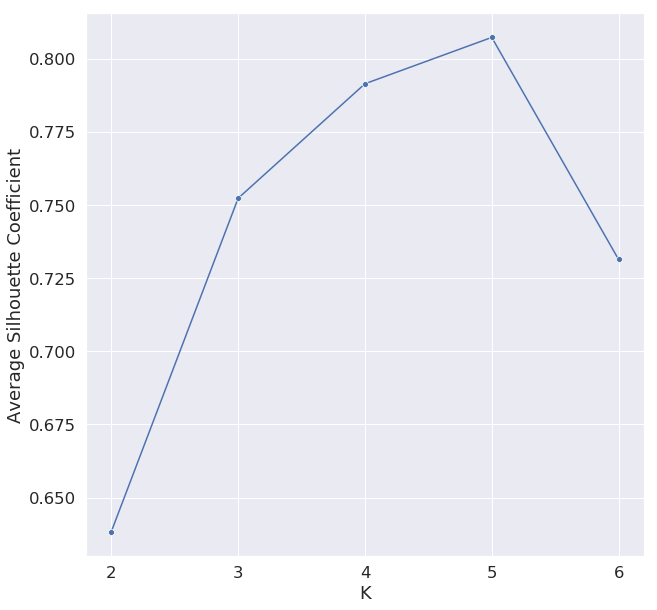

In [82]:
plt.subplots(figsize=(10,10))
kDF = pd.DataFrame(columns=['K','Average Silhouette Coefficient'])
kDF['K'] = KScores.keys()
kDF['Average Silhouette Coefficient'] = KScores.values()
sns.lineplot(data=kDF, x="K", y="Average Silhouette Coefficient", marker='o')
plt.xticks(np.arange(min(list(kDF['K'])), max(list(kDF['K']))+1, 1.0))
#plt.savefig("Silhouette_K_LineGraph.pdf", bbox_inches='tight', dpi=300)

In [83]:
#Give random state so reproducible
clustering = KMeans(n_clusters=5, random_state=8).fit(pcaClusterDF)

pcaClusterDF['Km'] = clustering.labels_
pcaClusterDF['Clusters'] = 'temp'

for i in pcaClusterDF.index:
    pcaClusterDF.at[i,'Clusters'] = str("Cluster: ")+str(pcaClusterDF.at[i,'Km']+1)

In [84]:
pcaClusterDF2 = pcaClusterDF.drop(columns=['Km']).copy()
pcaClusterDF2['Cluster'] = 'temp'
for i in pcaClusterDF.index:
    if pcaClusterDF.at[i,'Clusters'] == 'Cluster: 5':
        pcaClusterDF2.at[i,'Cluster'] = 'Cluster: 2'
    elif pcaClusterDF.at[i,'Clusters'] == 'Cluster: 2':
        pcaClusterDF2.at[i,'Cluster'] = 'Cluster: 1'
    elif pcaClusterDF.at[i,'Clusters'] == 'Cluster: 4':
        pcaClusterDF2.at[i,'Cluster'] = 'Cluster: 5'
    elif pcaClusterDF.at[i,'Clusters'] == 'Cluster: 3':
        pcaClusterDF2.at[i,'Cluster'] = 'Cluster: 3'
    elif pcaClusterDF.at[i,'Clusters'] == 'Cluster: 1':
        pcaClusterDF2.at[i,'Cluster'] = 'Cluster: 4'
    else:
        continue
pcaClusterDF2.drop(columns=['Clusters'], inplace=True)
pcaClusterDF2.rename(columns={'Cluster':'Clusters'},inplace=True)
pcaClusterDF2

,principal component 1,principal component 2,Clusters
Organism,,,
CRC_Module_0,-127.553808,198.544927,Cluster: 2
CRC_Module_1,321.903995,7.229735,Cluster: 1
CRC_Module_2,-132.246086,330.899610,Cluster: 3
CRC_Module_3,39.957428,-124.528872,Cluster: 4
CRC_Module_4,-172.540878,-94.123058,Cluster: 5
CRC_Module_5,68.700480,-113.199706,Cluster: 4
CRC_Module_6,-167.440738,-90.846277,Cluster: 5
CRC_Module_7,-179.377754,-114.254962,Cluster: 5
CRC_Module_8,-20.676277,-116.970491,Cluster: 4


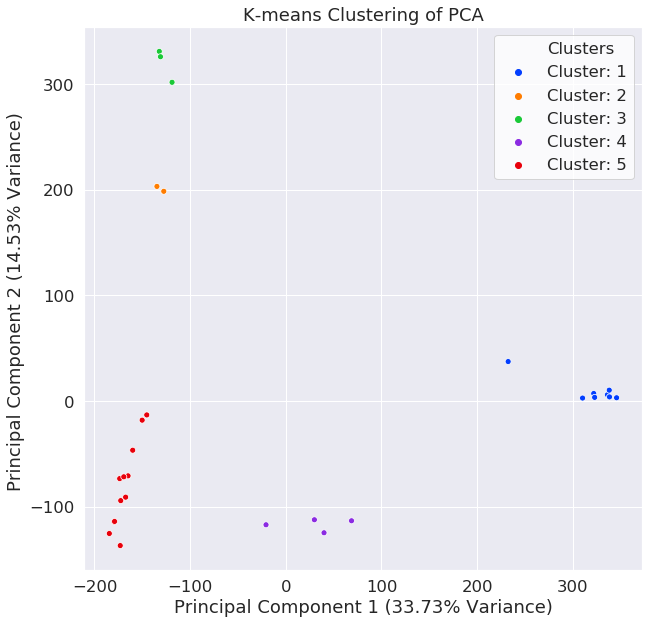

In [85]:
plt.figure(figsize = (10,10))
ClusterColorlegend = {"Cluster: 1":"#023eff","Cluster: 2":"#ff7c00","Cluster: 3":"#1ac938","Cluster: 4":"#8b2be2","Cluster: 5":"#e8000b"}
sns.scatterplot(palette=ClusterColorlegend, data=pcaClusterDF2.sort_values(by=['Clusters']), x="principal component 1", y="principal component 2", hue="Clusters")
plt.title('K-means Clustering of PCA')
plt.xlabel('Principal Component 1 (33.73% Variance)')
plt.ylabel('Principal Component 2 (14.53% Variance) ')
plt.legend(facecolor='white')
#plt.savefig("KMEANS_Module_functionality.pdf", bbox_inches='tight', dpi=300)
plt.show()

## Run Multiple PCAs for cluster functional analysis

In [86]:
ClusterColors = {"Cluster: 1":"#023eff","Cluster: 2":"#ff7c00","Cluster: 3":"#1ac938","Cluster: 4":"#8b2be2","Cluster: 5":"#e8000b"}

In [87]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def runPCA_cluster(dataframe, filename, title, targets):
    
    pcaDF2 = dataframe.reset_index().drop("Bacterial_Species",axis=1).copy()
    pcaDF3 = pcaDF2.drop("Cluster", axis=1).copy()
    features = pcaDF3.columns
    x = pcaDF3.loc[:, features].values
    y = pcaDF2.loc[:,['Cluster']].values
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2']).copy()
    finalDf = pd.concat([principalDf, pcaDF2[['Cluster']]], axis = 1).copy()
    import seaborn as sns
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 11.7,8.27
    palette ={targets[0]:ClusterColors[targets[0]], targets[1]:ClusterColors[targets[1]]}

    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1 ('+str("%.2f" % (100*pca.explained_variance_ratio_[0]))+"% variance)", labelpad=15)
    ax.set_ylabel('Principal Component 2 ('+str("%.2f" % (100*pca.explained_variance_ratio_[1]))+"% variance)", labelpad=15)
    ax.set_title('Principal Component Analysis ('+title+')')

    targets = targets # ['Healthy','CRC']

    colors =  [ClusterColors[targets[0]], ClusterColors[targets[1]]]
    
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf ['Cluster'] == target
        ax.scatter(finalDf .loc[indicesToKeep, 'principal component 1']
                   , finalDf .loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , s = 50, alpha=0.5)
        
    ax.legend(targets, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, title='Cohorts')
    rcParams['figure.figsize'] = 11.7,8.27
    ax = sns.set(font_scale=1.5)
    #plt.savefig("./Files/"+filename+".pdf", dpi=300, bbox_inches='tight')
    plt.show()

In [88]:
cluster_1 = [x for x in pcaClusterDF2[pcaClusterDF2['Clusters']=='Cluster: 1'].index]
cluster_2 = [x for x in pcaClusterDF2[pcaClusterDF2['Clusters']=='Cluster: 2'].index]
cluster_3 = [x for x in pcaClusterDF2[pcaClusterDF2['Clusters']=='Cluster: 3'].index]
cluster_4 = [x for x in pcaClusterDF2[pcaClusterDF2['Clusters']=='Cluster: 4'].index]
cluster_5 = [x for x in pcaClusterDF2[pcaClusterDF2['Clusters']=='Cluster: 5'].index]

In [89]:
clusterDF = allMDF3.drop(columns=['Cohort']).copy()
clusterDF['Cluster'] = pcaClusterDF2['Clusters'].copy()
clusterDF.head()

,PF12395,PF18810,PF03118,PF00701,PF17866,PF11185,PF15565,PF14437,PF13493,PF02595,...,PF01862,PF06831,PF05609,PF06574,PF01018,PF00793,PF13802,PF12811,PF16439,Cluster
Bacterial_Species,,,,,,,,,,,,,,,,,,,,,
CRC_Module_0,-5.784876,-5.784876,9.584050,9.625276,8.553363,-5.784876,-5.784876,9.584050,-5.784876,7.714549,...,-5.784876,7.714549,-5.784876,9.584050,9.584050,9.235184,-5.784876,-5.784876,-5.784876,Cluster: 2
CRC_Module_1,-6.873267,-6.873267,8.509336,8.692883,7.525416,3.052558,-6.873267,7.753238,-6.873267,7.584037,...,-6.873267,-6.873267,-6.873267,7.753238,7.753238,8.446386,8.155781,-6.873267,-6.873267,Cluster: 1
CRC_Module_2,-5.594297,-5.594297,9.565016,10.206770,8.916723,6.918341,-5.594297,9.565016,-5.594297,9.491492,...,-5.594297,9.491492,-5.594297,9.565016,9.565016,9.649485,-5.594297,-5.594297,-5.594297,Cluster: 3
CRC_Module_3,4.312704,2.554792,4.772423,5.596504,4.961917,4.300655,-9.953467,4.731724,4.937915,3.909260,...,-9.953467,0.123412,-9.953467,4.731724,4.731724,5.363410,4.613485,-9.953467,-9.953467,Cluster: 4
CRC_Module_4,-7.021512,-7.021512,8.017793,8.615902,5.211709,5.211709,-7.021512,7.714671,8.113008,7.714671,...,-7.021512,6.056022,-7.021512,7.714671,7.714671,7.955449,5.211709,-7.021512,-7.021512,Cluster: 5


In [90]:
clusterFeatureDF = pd.DataFrame(index=['Cluster: 1', 'Cluster: 2','Cluster: 3','Cluster: 4','Cluster: 5'], columns=clusterDF.drop(columns=['Cluster']).columns).fillna(0.0)
clusterFeatureDF.head()

,PF12395,PF18810,PF03118,PF00701,PF17866,PF11185,PF15565,PF14437,PF13493,PF02595,...,PF18657,PF01862,PF06831,PF05609,PF06574,PF01018,PF00793,PF13802,PF12811,PF16439
Cluster: 1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cluster: 2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cluster: 3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cluster: 4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cluster: 5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pullFeatureImportance_clusters(dataframe):
    
    pcaDF2 = dataframe.reset_index().drop("Bacterial_Species",axis=1).copy()
    pcaDF3 = pcaDF2.drop(columns=["Cluster"], axis=1).copy()
    features = pcaDF3.columns
    x = pcaDF3.loc[:, features].values
    y = pcaDF2.loc[:,['Cluster']].values
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2']).copy()
    finalDf = pd.concat([principalDf, pcaDF2[['Cluster']]], axis = 1).copy()
    
    return (pd.DataFrame(pca.components_,columns=pcaDF3.columns,index = ['PC-1','PC-2']))

In [92]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def runPCA3_cluster(dataframe, clusters , featureDF):
    
    featureDF_trim = featureDF.loc[clusters].copy()
    
    
    pcaDF2 = dataframe.reset_index().drop("Bacterial_Species",axis=1).copy()
    pcaDF3 = pcaDF2.drop(["Cluster"], axis=1).copy()
    features = pcaDF3.columns
    x = pcaDF3.loc[:, features].values
    y = pcaDF2.loc[:,['Cluster']].values
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2']).copy()
    finalDf = pd.concat([principalDf, pcaDF2[['Cluster']]], axis = 1).copy()
    finalDf['Organism'] = list(dataframe.index)
    
    
    #Find out which cluster is the positive cluster
    testDF = finalDf.sort_values(by='principal component 1', ascending=False).copy()
    PosCluster = 'temp'
    for cluster in testDF[testDF['principal component 1'] > 0]['Cluster']:
        PosCluster = (cluster)
        break
        
    
    #Which cluster is the negative cluster
    negCluster = clusters.copy()
    negCluster.remove(PosCluster)
    
    
    featureImportanceDF_Pfam = pullFeatureImportance_clusters(dataframe).loc['PC-1']
    for feature in featureImportanceDF_Pfam.index:
        if abs(featureImportanceDF_Pfam.loc[feature]) >= 0.01:
            if featureImportanceDF_Pfam.loc[feature] > 0:
                featureDF_trim.at[PosCluster,feature] += abs(featureImportanceDF_Pfam.loc[feature])
            else:
                featureDF_trim.at[negCluster[0],feature] += abs(featureImportanceDF_Pfam.loc[feature])
        else:
            continue
    
    return(featureDF_trim)

In [93]:
c_1_2 = runPCA3_cluster(clusterDF.loc[cluster_1+cluster_2], ['Cluster: 1', 'Cluster: 2'], clusterFeatureDF)
c_1_3 = runPCA3_cluster(clusterDF.loc[cluster_1+cluster_3], ['Cluster: 1', 'Cluster: 3'], clusterFeatureDF)
c_1_4 = runPCA3_cluster(clusterDF.loc[cluster_1+cluster_4], ['Cluster: 1', 'Cluster: 4'], clusterFeatureDF)
c_1_5 = runPCA3_cluster(clusterDF.loc[cluster_1+cluster_5], ['Cluster: 1', 'Cluster: 5'], clusterFeatureDF)

c_2_3 = runPCA3_cluster(clusterDF.loc[cluster_2+cluster_2], ['Cluster: 2', 'Cluster: 3'], clusterFeatureDF)
c_2_4 = runPCA3_cluster(clusterDF.loc[cluster_2+cluster_2], ['Cluster: 2', 'Cluster: 4'], clusterFeatureDF)
c_2_5 = runPCA3_cluster(clusterDF.loc[cluster_2+cluster_2], ['Cluster: 2', 'Cluster: 5'], clusterFeatureDF)

c_3_4 = runPCA3_cluster(clusterDF.loc[cluster_3+cluster_4], ['Cluster: 3', 'Cluster: 4'], clusterFeatureDF)
c_3_5 = runPCA3_cluster(clusterDF.loc[cluster_3+cluster_5], ['Cluster: 3', 'Cluster: 5'], clusterFeatureDF)

c_4_5 = runPCA3_cluster(clusterDF.loc[cluster_4+cluster_5], ['Cluster: 4', 'Cluster: 5'], clusterFeatureDF)

In [94]:
c_1_2

,PF12395,PF18810,PF03118,PF00701,PF17866,PF11185,PF15565,PF14437,PF13493,PF02595,...,PF18657,PF01862,PF06831,PF05609,PF06574,PF01018,PF00793,PF13802,PF12811,PF16439
Cluster: 1,0.0,0.0,0.0,0.0,0.000000,0.020584,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.022481,0.0,0.0
Cluster: 2,0.0,0.0,0.0,0.0,0.011243,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.011064,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [95]:
allClusterComparison = pd.concat([c_1_2,c_1_3,c_1_4,c_1_5,c_2_3,c_2_4,c_2_5,c_3_4,c_3_5,c_4_5])
clusterComp = allClusterComparison.replace(0.0, np.nan).dropna(axis=1, thresh=1).fillna(0.0)
FinalCluserComp = clusterComp.groupby(clusterComp.index).sum().copy()

In [96]:
FinalCluserComp

,PF12395,PF18810,PF03118,PF17866,PF11185,PF15565,PF14437,PF13493,PF02595,PF07751,...,PF17910,PF13385,PF18657,PF01862,PF06831,PF05609,PF06574,PF01018,PF13802,PF12811
Cluster: 1,0.000000,0.00000,0.000000,0.000000,0.020584,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.064995,0.000000,0.01907,0.000000,0.000000,0.000000,0.000000,0.043962,0.000000
Cluster: 2,0.000000,0.00000,0.000000,0.011243,0.000000,0.000000,0.000000,0.000000,0.000000,0.238974,...,0.000000,0.000000,0.000000,0.00000,0.011064,0.000000,0.000000,0.000000,0.000000,0.000000
Cluster: 3,0.000000,0.00000,0.000000,0.050067,0.000000,0.000000,0.000000,0.000000,0.010593,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.054439,0.000000,0.000000,0.000000,0.000000,0.000000
Cluster: 4,0.041350,0.01116,0.000000,0.000000,0.000000,0.000000,0.000000,0.046126,0.000000,0.000000,...,0.000000,0.047049,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.020593,0.000000
Cluster: 5,0.036607,0.00000,0.010305,0.000000,0.000000,0.023928,0.010437,0.050832,0.000000,0.000000,...,0.010773,0.015008,0.021985,0.00000,0.000000,0.014861,0.010511,0.010626,0.026625,0.015159


In [97]:
#FinalCluserComp.to_csv("PFAM_clusterFunctionality_PCA.csv")